<a href="https://www.kaggle.com/code/gpreda/electronic-health-records-ehrs-data-exploration?scriptVersionId=126749579" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction


In this Notebook we will explore data in Electronic Health Record (EHR) format.

We will perform the following operations:
- summarize the content of the dataset
- explore one file, to understand the data structure
- reformat the data, to transform it in dataframe format
- generalize the transformations we performed for one file to all the files.
- perform exploratory data analysis on the entire dataset
- summarize our findings

# Analysis preparation

In [1]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 50)
from tqdm import tqdm

# Read the data

## Explore the file structure

In [2]:
file_path_list = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_path_list.append((dirname, filename))

In [3]:
metadata_df = pd.DataFrame(file_path_list, columns=["folder", "file"])

In [4]:
print(f"Files: {metadata_df.shape[0]}")

Files: 129218


In [5]:
metadata_df.head()

,folder,file
0,/kaggle/input/synthea-dataset-jsons-ehr/fhir/d...,d8cddeba-4cf8-412a-86de-b9af0a6a185b.json
1,/kaggle/input/synthea-dataset-jsons-ehr/fhir/d...,d8c4806e-0837-47cc-8500-a1e06e09fc8f.json
2,/kaggle/input/synthea-dataset-jsons-ehr/fhir/d...,d8c1a196-9323-4dbf-a693-ffb68a713189.json
3,/kaggle/input/synthea-dataset-jsons-ehr/fhir/d...,d8c626ec-07f7-4502-bae6-0010033c061a.json
4,/kaggle/input/synthea-dataset-jsons-ehr/fhir/d...,d8cd922c-c607-47e5-801c-ad199061d806.json


## Add group and subgroup information

In [6]:
def extract_subgroup(path):
    return path.split("/")[-1]

def extract_group(path):
    return path.split("/")[-2]


In [7]:
metadata_df["group"] = metadata_df["folder"].apply(lambda x: extract_group(x))
metadata_df["subgroup"] = metadata_df["folder"].apply(lambda x: extract_subgroup(x))

In [8]:
metadata_df = metadata_df[["folder", "group", "subgroup", "file"]]

In [9]:
metadata_df.head()

,folder,group,subgroup,file
0,/kaggle/input/synthea-dataset-jsons-ehr/fhir/d...,d8,d8c,d8cddeba-4cf8-412a-86de-b9af0a6a185b.json
1,/kaggle/input/synthea-dataset-jsons-ehr/fhir/d...,d8,d8c,d8c4806e-0837-47cc-8500-a1e06e09fc8f.json
2,/kaggle/input/synthea-dataset-jsons-ehr/fhir/d...,d8,d8c,d8c1a196-9323-4dbf-a693-ffb68a713189.json
3,/kaggle/input/synthea-dataset-jsons-ehr/fhir/d...,d8,d8c,d8c626ec-07f7-4502-bae6-0010033c061a.json
4,/kaggle/input/synthea-dataset-jsons-ehr/fhir/d...,d8,d8c,d8cd922c-c607-47e5-801c-ad199061d806.json


In [10]:
print(f"Folders: {metadata_df.folder.nunique()}")
print(f"Groups: {metadata_df.group.nunique()}")
print(f"Subgroups: {metadata_df.subgroup.nunique()}")
print(f"Files: {metadata_df.file.nunique()}")

Folders: 4080
Groups: 255
Subgroups: 4080
Files: 129218


## Read one file

We read and we will explore one sample data file.

In [11]:
sample_df= pd.read_json('/kaggle/input/synthea-dataset-jsons-ehr/fhir/d8/d8c/d8cddeba-4cf8-412a-86de-b9af0a6a185b.json')

In [12]:
sample_df.head()

,type,entry,resourceType
0,collection,{'fullUrl': 'urn:uuid:f7b73132-64f0-462b-8ca5-...,Bundle
1,collection,{'fullUrl': 'urn:uuid:ab801624-bfef-410f-8e75-...,Bundle
2,collection,{'fullUrl': 'urn:uuid:224407fa-cf73-41d2-aee3-...,Bundle
3,collection,{'fullUrl': 'urn:uuid:d66f0cc2-20f0-49b0-9883-...,Bundle
4,collection,{'fullUrl': 'urn:uuid:63f1c8f9-279c-4fae-8aef-...,Bundle


# Data exploration

## Import and process one sample file

In [13]:
patient_df = pd.DataFrame() 
careplan_df = pd.DataFrame() 
condition_df = pd.DataFrame() 
diagnostic_report_df = pd.DataFrame() 
encounter_df = pd.DataFrame() 
immunization_df = pd.DataFrame() 
observation_df = pd.DataFrame() 
procedure_df = pd.DataFrame() 

In [14]:
def process_one_file(sample_df,
                    patient_df,
                    careplan_df,
                    condition_df,
                    diagnostic_report_df,
                    encounter_df,
                    immunization_df,
                    observation_df,
                    procedure_df):
    
    dataframe_list = [patient_df, careplan_df, condition_df, diagnostic_report_df,
                 encounter_df, immunization_df, observation_df, procedure_df]
    
    for index, row in sample_df.iterrows():
        resourcetype=set()
        tempdf=pd.json_normalize(row.entry)
        resourcetype.add([str(x) for x in tempdf['resource.resourceType']][0])

        if str(tempdf['resource.resourceType'][0])=="Patient":
            frames = [patient_df, tempdf]
            patient_df = pd.concat(frames)

        elif str(tempdf['resource.resourceType'][0])=="CarePlan":
            frames = [careplan_df, tempdf]
            careplan_df = pd.concat(frames)

        elif str(tempdf['resource.resourceType'][0])=="Condition":
            frames = [condition_df, tempdf]
            condition_df = pd.concat(frames)

        elif str(tempdf['resource.resourceType'][0])=="DiagnosticReport":
            frames = [diagnostic_report_df, tempdf]
            diagnostic_report_df = pd.concat(frames)

        elif str(tempdf['resource.resourceType'][0])=="Encounter":
            frames = [encounter_df, tempdf]
            encounter_df = pd.concat(frames)

        elif str(tempdf['resource.resourceType'][0])=="Immunization":
            frames = [immunization_df, tempdf]
            immunization_df = pd.concat(frames)

        elif str(tempdf['resource.resourceType'][0])=="Observation":
            frames = [observation_df, tempdf]
            observation_df = pd.concat(frames)

        elif str(tempdf['resource.resourceType'][0])=="Procedure":
            frames = [procedure_df, tempdf]
            procedure_df = pd.concat(frames)   

    return patient_df,\
                    careplan_df,\
                    condition_df,\
                    diagnostic_report_df,\
                    encounter_df,\
                    immunization_df,\
                    observation_df,\
                    procedure_df

In [15]:
def clean_and_rename(patient_df,
                    careplan_df,
                    condition_df,
                    diagnostic_report_df,
                    encounter_df,
                    immunization_df,
                    observation_df,
                    procedure_df):
    for df in [patient_df, careplan_df, condition_df, diagnostic_report_df,
                 encounter_df, immunization_df, observation_df, procedure_df]:
        df.columns = df.columns.str.replace(".", "_")
        df.columns = df.columns.str.replace("resource_", "")
    
    for df in [patient_df, observation_df, encounter_df]:
        df['fullUrl']= df['fullUrl'].str.replace('urn:uuid:', '')
        
    #for df in [careplan_df, condition_df, diagnostic_report_df]:
    #    df['subject_reference']=df['subject_reference'].str.replace('urn:uuid:', '')
    #    df['context_reference']=df['context_reference'].str.replace('urn:uuid:', '')
    
    for df in [encounter_df, immunization_df]:
        df['patient_reference'] = df['patient_reference'].str.replace('urn:uuid:', '')
        
    for df in [immunization_df]:
        df['encounter_reference'] = df['encounter_reference'].str.replace('urn:uuid:', '')
        
    for df in [observation_df, procedure_df]:
        df['subject_reference'] = df['subject_reference'].str.replace('urn:uuid:', '')
        df['encounter_reference'] = df['encounter_reference'].str.replace('urn:uuid:', '')
        
    return patient_df,\
                    careplan_df,\
                    condition_df,\
                    diagnostic_report_df,\
                    encounter_df,\
                    immunization_df,\
                    observation_df,\
                    procedure_df

In [16]:
patient_df,\
careplan_df,\
condition_df,\
diagnostic_report_df,\
encounter_df,\
immunization_df,\
observation_df,\
procedure_df = \
process_one_file(sample_df,patient_df,
careplan_df,
condition_df,
diagnostic_report_df,
encounter_df,
immunization_df,
observation_df,
procedure_df)

In [17]:
patient_df.head()

,fullUrl,resource.id,resource.text.status,resource.text.div,resource.extension,resource.identifier,resource.name,resource.telecom,resource.gender,resource.birthDate,resource.address,resource.maritalStatus.coding,resource.multipleBirthBoolean,resource.photo,resource.resourceType
0,urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,f7b73132-64f0-462b-8ca5-94dc5205b297,generated,"<div>Generated by <a href=""https://github.com/...",[{'url': 'http://hl7.org/fhir/StructureDefinit...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Botsford730', ...",[{'extension': [{'url': 'http://standardhealth...,male,1987-10-12,[{'extension': [{'extension': [{'url': 'latitu...,[{'system': 'http://hl7.org/fhir/v3/MaritalSta...,False,"[{'contentType': 'image/png', 'data': 'iVBORw0...",Patient


In [18]:
careplan_df.head()

,resource.status,resource.category,resource.subject.reference,resource.context.reference,resource.period.start,resource.addresses,resource.activity,resource.resourceType
0,active,[{'coding': [{'system': 'http://snomed.info/sc...,urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,urn:uuid:ab801624-bfef-410f-8e75-e66f7b363bc4,2008-07-28,[{'reference': 'urn:uuid:63f1c8f9-279c-4fae-8a...,[{'detail': {'code': {'coding': [{'system': 'h...,CarePlan


In [19]:
condition_df.head()

,fullUrl,resource.id,resource.clinicalStatus,resource.verificationStatus,resource.code.coding,resource.subject.reference,resource.context.reference,resource.onsetDateTime,resource.abatementDateTime,resource.resourceType
0,urn:uuid:224407fa-cf73-41d2-aee3-167b974b6633,224407fa-cf73-41d2-aee3-167b974b6633,active,confirmed,"[{'system': 'http://snomed.info/sct', 'code': ...",urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,urn:uuid:ab801624-bfef-410f-8e75-e66f7b363bc4,2000-08-21T22:51:57-04:00,2000-09-07T20:05:34-04:00,Condition
0,urn:uuid:d66f0cc2-20f0-49b0-9883-0b604832184f,d66f0cc2-20f0-49b0-9883-0b604832184f,active,confirmed,"[{'system': 'http://snomed.info/sct', 'code': ...",urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,urn:uuid:ab801624-bfef-410f-8e75-e66f7b363bc4,2006-09-20T16:28:19-04:00,NaN,Condition
0,urn:uuid:63f1c8f9-279c-4fae-8aef-8604307dc65c,63f1c8f9-279c-4fae-8aef-8604307dc65c,active,confirmed,"[{'system': 'http://snomed.info/sct', 'code': ...",urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,urn:uuid:ab801624-bfef-410f-8e75-e66f7b363bc4,2008-07-28T17:00:46-04:00,NaN,Condition


In [20]:
diagnostic_report_df.head()

,fullUrl,resource.id,resource.status,resource.code.coding,resource.subject.reference,resource.encounter.reference,resource.effectiveDateTime,resource.issued,resource.performer,resource.result,resource.resourceType
0,urn:uuid:844d8e72-084e-481a-b8f6-c98be10cc3b1,844d8e72-084e-481a-b8f6-c98be10cc3b1,final,"[{'system': 'http://loinc.org', 'code': '51990...",urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,urn:uuid:ab801624-bfef-410f-8e75-e66f7b363bc4,2011-10-29T15:35:57-04:00,2011-10-29T15:35:57-04:00,[{'display': 'Hospital Lab'}],[{'reference': 'urn:uuid:8c1c89df-e12b-4f92-b7...,DiagnosticReport
0,urn:uuid:57b3256b-6e9e-44f7-bc5d-4866a3527ad3,57b3256b-6e9e-44f7-bc5d-4866a3527ad3,final,"[{'system': 'http://loinc.org', 'code': '51990...",urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,urn:uuid:3c518c40-bf0c-4753-a13f-dff041711fa3,2014-03-06T05:41:14-05:00,2014-03-06T05:41:14-05:00,[{'display': 'Hospital Lab'}],[{'reference': 'urn:uuid:c439ff53-9613-420e-81...,DiagnosticReport
0,urn:uuid:457e6568-8b00-4a28-abb1-c9da5994f328,457e6568-8b00-4a28-abb1-c9da5994f328,final,"[{'system': 'http://loinc.org', 'code': '51990...",urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,urn:uuid:cb103937-851c-4211-96b2-fcd10de66738,2017-02-12T13:59:38-05:00,2017-02-12T13:59:38-05:00,[{'display': 'Hospital Lab'}],[{'reference': 'urn:uuid:24e24f09-27a3-4751-8e...,DiagnosticReport


In [21]:
encounter_df.head()

,fullUrl,resource.id,resource.status,resource.class.code,resource.type,resource.patient.reference,resource.period.start,resource.period.end,resource.resourceType
0,urn:uuid:ab801624-bfef-410f-8e75-e66f7b363bc4,ab801624-bfef-410f-8e75-e66f7b363bc4,finished,outpatient,[{'coding': [{'system': 'http://snomed.info/sc...,urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,2011-10-29T15:35:57-04:00,2011-10-29T16:35:57-04:00,Encounter
0,urn:uuid:3c518c40-bf0c-4753-a13f-dff041711fa3,3c518c40-bf0c-4753-a13f-dff041711fa3,finished,outpatient,[{'coding': [{'system': 'http://snomed.info/sc...,urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,2014-03-06T05:41:14-05:00,2014-03-06T06:41:14-05:00,Encounter
0,urn:uuid:cb103937-851c-4211-96b2-fcd10de66738,cb103937-851c-4211-96b2-fcd10de66738,finished,outpatient,[{'coding': [{'system': 'http://snomed.info/sc...,urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,2017-02-12T13:59:38-05:00,2017-02-12T14:59:38-05:00,Encounter


In [22]:
immunization_df.head()

,resource.status,resource.date,resource.vaccineCode.coding,resource.patient.reference,resource.wasNotGiven,resource.primarySource,resource.encounter.reference,resource.resourceType
0,completed,2011-10-29T15:35:57-04:00,"[{'system': 'http://hl7.org/fhir/sid/cvx', 'co...",urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,False,True,urn:uuid:ab801624-bfef-410f-8e75-e66f7b363bc4,Immunization
0,completed,2011-10-29T15:35:57-04:00,"[{'system': 'http://hl7.org/fhir/sid/cvx', 'co...",urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,False,True,urn:uuid:ab801624-bfef-410f-8e75-e66f7b363bc4,Immunization
0,completed,2014-03-06T05:41:14-05:00,"[{'system': 'http://hl7.org/fhir/sid/cvx', 'co...",urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,False,True,urn:uuid:3c518c40-bf0c-4753-a13f-dff041711fa3,Immunization
0,completed,2017-02-12T13:59:38-05:00,"[{'system': 'http://hl7.org/fhir/sid/cvx', 'co...",urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,False,True,urn:uuid:cb103937-851c-4211-96b2-fcd10de66738,Immunization


In [23]:
observation_df.head()

,fullUrl,resource.id,resource.status,resource.code.coding,resource.subject.reference,resource.encounter.reference,resource.effectiveDateTime,resource.valueQuantity.value,resource.valueQuantity.unit,resource.valueQuantity.system,resource.valueQuantity.code,resource.resourceType,resource.component
0,urn:uuid:25237765-4735-4ab8-89dd-1369732c4909,25237765-4735-4ab8-89dd-1369732c4909,final,"[{'system': 'http://loinc.org', 'code': '4548-...",urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,urn:uuid:ab801624-bfef-410f-8e75-e66f7b363bc4,2011-10-29T15:35:57-04:00,5.900000,%,http://unitsofmeasure.org/,%,Observation,NaN
0,urn:uuid:78022e05-fc27-4671-b3f5-22dd2e6064ca,78022e05-fc27-4671-b3f5-22dd2e6064ca,final,"[{'system': 'http://loinc.org', 'code': '8302-...",urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,urn:uuid:ab801624-bfef-410f-8e75-e66f7b363bc4,2011-10-29T15:35:57-04:00,163.440620,cm,http://unitsofmeasure.org/,cm,Observation,NaN
0,urn:uuid:2a394421-6de6-4268-96e4-fe912628a03f,2a394421-6de6-4268-96e4-fe912628a03f,final,"[{'system': 'http://loinc.org', 'code': '29463...",urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,urn:uuid:ab801624-bfef-410f-8e75-e66f7b363bc4,2011-10-29T15:35:57-04:00,80.173659,kg,http://unitsofmeasure.org/,kg,Observation,NaN
0,urn:uuid:335a592c-dedf-4edc-b96e-2718a1c812ac,335a592c-dedf-4edc-b96e-2718a1c812ac,final,"[{'system': 'http://loinc.org', 'code': '39156...",urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,urn:uuid:ab801624-bfef-410f-8e75-e66f7b363bc4,2011-10-29T15:35:57-04:00,30.013159,kg/m2,http://unitsofmeasure.org/,kg/m2,Observation,NaN
0,urn:uuid:c5427cd4-0bc3-4bf5-97ae-870a0c5d25dd,c5427cd4-0bc3-4bf5-97ae-870a0c5d25dd,final,"[{'system': 'http://loinc.org', 'code': '55284...",urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,urn:uuid:ab801624-bfef-410f-8e75-e66f7b363bc4,2011-10-29T15:35:57-04:00,NaN,NaN,NaN,NaN,Observation,[{'code': {'coding': [{'system': 'http://loinc...


In [24]:
procedure_df

,resource.status,resource.code.coding,resource.code.text,resource.subject.reference,resource.encounter.reference,resource.performedDateTime,resource.resourceType
0,completed,"[{'system': 'http://snomed.info/sct', 'code': ...",Documentation of current medications,urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,urn:uuid:ab801624-bfef-410f-8e75-e66f7b363bc4,2011-10-29T15:35:57-04:00,Procedure


## Import and process a group of files


Let's import an entire group of files. We will pick few groups with the largest size.

In [25]:
sel_index = list(metadata_df.group.value_counts()[0:2].index)
sel_index

['d6', 'e1']

In [26]:
group_df = metadata_df.loc[metadata_df.group.isin(sel_index)]

In [27]:
group_df.shape[0], group_df.shape[0] / metadata_df.shape[0]

(1119, 0.008659784240585677)

We will select only first 1.1K entries, or less than 1% of the data.

In [28]:
patient_df = pd.DataFrame() 
careplan_df = pd.DataFrame() 
condition_df = pd.DataFrame() 
diagnostic_report_df = pd.DataFrame() 
encounter_df = pd.DataFrame() 
immunization_df = pd.DataFrame() 
observation_df = pd.DataFrame() 
procedure_df = pd.DataFrame() 

In [29]:
for index, row in tqdm(group_df.iterrows()):
    folder = row["folder"]
    file = row["file"]
    sample_df = pd.read_json(os.path.join(folder, file))
    patient_df,\
    careplan_df,\
    condition_df,\
    diagnostic_report_df,\
    encounter_df,\
    immunization_df,\
    observation_df,\
    procedure_df = \
    process_one_file(sample_df,patient_df,
    careplan_df,
    condition_df,
    diagnostic_report_df,
    encounter_df,
    immunization_df,
    observation_df,
    procedure_df)

1119it [09:53,  1.89it/s]


Let's check the data size for each dimmension.

In [30]:
patient_df.shape[0], careplan_df.shape[0], condition_df.shape[0], diagnostic_report_df.shape[0], encounter_df.shape[0], immunization_df.shape[0],\
observation_df.shape[0], procedure_df.shape[0]

(1119, 2115, 4125, 2681, 10298, 7421, 41520, 4757)

In [31]:
for df in [patient_df, careplan_df, condition_df, diagnostic_report_df, encounter_df, immunization_df, observation_df,procedure_df]:
    print(df.columns)

Index(['fullUrl', 'resource.id', 'resource.text.status', 'resource.text.div',
       'resource.extension', 'resource.identifier', 'resource.name',
       'resource.telecom', 'resource.gender', 'resource.birthDate',
       'resource.address', 'resource.multipleBirthBoolean', 'resource.photo',
       'resource.resourceType', 'resource.maritalStatus.coding',
       'resource.multipleBirthInteger', 'resource.deceasedDateTime'],
      dtype='object')
Index(['resource.status', 'resource.category', 'resource.subject.reference',
       'resource.context.reference', 'resource.period.start',
       'resource.addresses', 'resource.activity', 'resource.resourceType',
       'resource.period.end'],
      dtype='object')
Index(['fullUrl', 'resource.id', 'resource.clinicalStatus',
       'resource.verificationStatus', 'resource.code.coding',
       'resource.subject.reference', 'resource.context.reference',
       'resource.onsetDateTime', 'resource.abatementDateTime',
       'resource.resourceType']

In [32]:
patient_df.head()

,fullUrl,resource.id,resource.text.status,resource.text.div,resource.extension,resource.identifier,resource.name,resource.telecom,resource.gender,resource.birthDate,resource.address,resource.multipleBirthBoolean,resource.photo,resource.resourceType,resource.maritalStatus.coding,resource.multipleBirthInteger,resource.deceasedDateTime
0,urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,c0be7c6f-142e-4598-b7a4-aa6a4a75588a,generated,"<div>Generated by <a href=""https://github.com/...",[{'url': 'http://hl7.org/fhir/StructureDefinit...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Mitchell592', ...",[{'extension': [{'url': 'http://standardhealth...,female,1990-03-15,[{'extension': [{'extension': [{'url': 'latitu...,False,"[{'contentType': 'image/png', 'data': 'iVBORw0...",Patient,NaN,NaN,NaN
0,urn:uuid:fa50a4ca-7511-4c19-9196-732fac5eeba4,fa50a4ca-7511-4c19-9196-732fac5eeba4,generated,"<div>Generated by <a href=""https://github.com/...",[{'url': 'http://hl7.org/fhir/StructureDefinit...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Bode397', 'giv...",[{'extension': [{'url': 'http://standardhealth...,female,1952-12-31,[{'extension': [{'extension': [{'url': 'latitu...,False,"[{'contentType': 'image/png', 'data': 'iVBORw0...",Patient,[{'system': 'http://hl7.org/fhir/v3/MaritalSta...,NaN,NaN
0,urn:uuid:c3643672-320e-47f4-9f50-816d6048b95d,c3643672-320e-47f4-9f50-816d6048b95d,generated,"<div>Generated by <a href=""https://github.com/...",[{'url': 'http://hl7.org/fhir/StructureDefinit...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Schmidt555', '...",[{'extension': [{'url': 'http://standardhealth...,female,1965-06-10,[{'extension': [{'extension': [{'url': 'latitu...,False,"[{'contentType': 'image/png', 'data': 'iVBORw0...",Patient,[{'system': 'http://hl7.org/fhir/v3/MaritalSta...,NaN,NaN
0,urn:uuid:793ca0a2-f008-4715-bac8-4ae7c1448953,793ca0a2-f008-4715-bac8-4ae7c1448953,generated,"<div>Generated by <a href=""https://github.com/...",[{'url': 'http://hl7.org/fhir/StructureDefinit...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Renner102', 'g...",[{'extension': [{'url': 'http://standardhealth...,female,1968-03-24,[{'extension': [{'extension': [{'url': 'latitu...,NaN,"[{'contentType': 'image/png', 'data': 'iVBORw0...",Patient,[{'system': 'http://hl7.org/fhir/v3/MaritalSta...,2.0,NaN
0,urn:uuid:0349e7d7-24fc-4fc9-ae77-cee1559c7881,0349e7d7-24fc-4fc9-ae77-cee1559c7881,generated,"<div>Generated by <a href=""https://github.com/...",[{'url': 'http://hl7.org/fhir/StructureDefinit...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Hane154', 'giv...",[{'extension': [{'url': 'http://standardhealth...,female,1960-06-11,[{'extension': [{'extension': [{'url': 'latitu...,False,"[{'contentType': 'image/png', 'data': 'iVBORw0...",Patient,[{'system': 'http://hl7.org/fhir/v3/MaritalSta...,NaN,NaN


In [33]:
careplan_df.head()

,resource.status,resource.category,resource.subject.reference,resource.context.reference,resource.period.start,resource.addresses,resource.activity,resource.resourceType,resource.period.end
0,active,[{'coding': [{'system': 'http://snomed.info/sc...,urn:uuid:fa50a4ca-7511-4c19-9196-732fac5eeba4,urn:uuid:c5a70f91-06b6-4cd8-8605-0bcf2e5bdb2e,1987-02-18,[{'reference': 'urn:uuid:6d43368b-0606-4b70-8e...,[{'detail': {'code': {'coding': [{'system': 'h...,CarePlan,NaN
0,completed,[{'coding': [{'system': 'http://snomed.info/sc...,urn:uuid:fa50a4ca-7511-4c19-9196-732fac5eeba4,urn:uuid:edf9193e-52bd-47c9-a0e6-ba94fd2f60dc,2012-01-13,[{'reference': 'urn:uuid:66a6c308-2480-4f3f-80...,[{'detail': {'code': {'coding': [{'system': 'h...,CarePlan,2012-04-23
0,active,[{'coding': [{'system': 'http://snomed.info/sc...,urn:uuid:c3643672-320e-47f4-9f50-816d6048b95d,urn:uuid:5e7d75bb-b8c6-4498-aab8-073b4d48868e,2007-12-22,[{'reference': 'urn:uuid:2698b2dd-4ab9-413b-ab...,[{'detail': {'code': {'coding': [{'system': 'h...,CarePlan,NaN
0,completed,[{'coding': [{'system': 'http://snomed.info/sc...,urn:uuid:c3643672-320e-47f4-9f50-816d6048b95d,urn:uuid:5e7d75bb-b8c6-4498-aab8-073b4d48868e,2009-08-18,NaN,[{'detail': {'code': {'coding': [{'system': 'h...,CarePlan,2010-02-27
0,completed,[{'coding': [{'system': 'http://snomed.info/sc...,urn:uuid:c3643672-320e-47f4-9f50-816d6048b95d,urn:uuid:a979dff8-913c-4f06-bc98-278224ad058d,2010-11-29,[{'reference': 'urn:uuid:e63a7cb5-3044-4448-81...,[{'detail': {'code': {'coding': [{'system': 'h...,CarePlan,2010-12-06


In [34]:
condition_df.head()

,fullUrl,resource.id,resource.clinicalStatus,resource.verificationStatus,resource.code.coding,resource.subject.reference,resource.context.reference,resource.onsetDateTime,resource.abatementDateTime,resource.resourceType
0,urn:uuid:c1ed4ce3-6ddc-4f5a-8441-1c7a865a6869,c1ed4ce3-6ddc-4f5a-8441-1c7a865a6869,active,confirmed,"[{'system': 'http://snomed.info/sct', 'code': ...",urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,urn:uuid:9cf2f9f9-3450-48d6-a8a1-c1c3b857d68c,2012-08-09T16:40:11-04:00,2012-08-29T06:17:02-04:00,Condition
0,urn:uuid:393f4418-452d-49bc-92af-12a81db2f8b5,393f4418-452d-49bc-92af-12a81db2f8b5,active,confirmed,"[{'system': 'http://snomed.info/sct', 'code': ...",urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,urn:uuid:532982ed-207c-405e-b555-237db23f4a13,2014-10-06T17:24:01-04:00,2014-10-16T00:36:08-04:00,Condition
0,urn:uuid:6d43368b-0606-4b70-8e12-b906ca11cc41,6d43368b-0606-4b70-8e12-b906ca11cc41,active,confirmed,"[{'system': 'http://snomed.info/sct', 'code': ...",urn:uuid:fa50a4ca-7511-4c19-9196-732fac5eeba4,urn:uuid:c5a70f91-06b6-4cd8-8605-0bcf2e5bdb2e,1987-02-18T15:48:41-05:00,NaN,Condition
0,urn:uuid:66a6c308-2480-4f3f-8003-04522fbd1698,66a6c308-2480-4f3f-8003-04522fbd1698,active,confirmed,"[{'system': 'http://snomed.info/sct', 'code': ...",urn:uuid:fa50a4ca-7511-4c19-9196-732fac5eeba4,urn:uuid:edf9193e-52bd-47c9-a0e6-ba94fd2f60dc,2012-01-11T07:06:04-05:00,2012-01-24T12:40:48-05:00,Condition
0,urn:uuid:54ca3ea6-61b6-471c-b78b-26c4e7787c77,54ca3ea6-61b6-471c-b78b-26c4e7787c77,active,confirmed,"[{'system': 'http://snomed.info/sct', 'code': ...",urn:uuid:fa50a4ca-7511-4c19-9196-732fac5eeba4,urn:uuid:c4c974ef-46bd-49e4-8181-40cfc30c84be,2013-04-28T20:11:27-04:00,2013-05-12T04:59:44-04:00,Condition


In [35]:
diagnostic_report_df.head()

,fullUrl,resource.id,resource.status,resource.code.coding,resource.subject.reference,resource.encounter.reference,resource.effectiveDateTime,resource.issued,resource.performer,resource.result,resource.resourceType
0,urn:uuid:644daebf-5362-4eab-abe4-f9d0176c5b84,644daebf-5362-4eab-abe4-f9d0176c5b84,final,"[{'system': 'http://loinc.org', 'code': '51990...",urn:uuid:fa50a4ca-7511-4c19-9196-732fac5eeba4,urn:uuid:c5a70f91-06b6-4cd8-8605-0bcf2e5bdb2e,2010-04-18T04:33:04-04:00,2010-04-18T04:33:04-04:00,[{'display': 'Hospital Lab'}],[{'reference': 'urn:uuid:1620d733-ac12-456f-a9...,DiagnosticReport
0,urn:uuid:5bf9bb61-49f1-4c99-a25a-11955177d805,5bf9bb61-49f1-4c99-a25a-11955177d805,final,"[{'system': 'http://loinc.org', 'code': '57698...",urn:uuid:fa50a4ca-7511-4c19-9196-732fac5eeba4,urn:uuid:c5a70f91-06b6-4cd8-8605-0bcf2e5bdb2e,2010-04-18T04:33:04-04:00,2010-04-18T04:33:04-04:00,[{'display': 'Hospital Lab'}],[{'reference': 'urn:uuid:165f739f-a129-4a4f-b1...,DiagnosticReport
0,urn:uuid:5fc0714d-0ee0-4d68-8de2-976cb61d9866,5fc0714d-0ee0-4d68-8de2-976cb61d9866,final,"[{'system': 'http://loinc.org', 'code': '51990...",urn:uuid:fa50a4ca-7511-4c19-9196-732fac5eeba4,urn:uuid:dd8c0b74-266d-41f5-98d4-b98d432d5a73,2011-05-16T12:54:50-04:00,2011-05-16T12:54:50-04:00,[{'display': 'Hospital Lab'}],[{'reference': 'urn:uuid:6258e4e6-bde3-410d-80...,DiagnosticReport
0,urn:uuid:2b6f2f4e-8231-4cf0-b474-8aeb90051bc6,2b6f2f4e-8231-4cf0-b474-8aeb90051bc6,final,"[{'system': 'http://loinc.org', 'code': '51990...",urn:uuid:fa50a4ca-7511-4c19-9196-732fac5eeba4,urn:uuid:7c701691-29c4-456a-b094-34f48c3e2457,2012-04-23T17:16:58-04:00,2012-04-23T17:16:58-04:00,[{'display': 'Hospital Lab'}],[{'reference': 'urn:uuid:bd831908-d4a4-4d2c-a5...,DiagnosticReport
0,urn:uuid:d9cdb869-45ab-4a2c-8c20-ca1888c38714,d9cdb869-45ab-4a2c-8c20-ca1888c38714,final,"[{'system': 'http://loinc.org', 'code': '51990...",urn:uuid:fa50a4ca-7511-4c19-9196-732fac5eeba4,urn:uuid:4bea23d1-1026-412b-868d-1b7411f47a3f,2013-05-02T15:19:38-04:00,2013-05-02T15:19:38-04:00,[{'display': 'Hospital Lab'}],[{'reference': 'urn:uuid:b9245015-f893-4b6d-af...,DiagnosticReport


In [36]:
encounter_df.head()

,fullUrl,resource.id,resource.status,resource.class.code,resource.type,resource.patient.reference,resource.period.start,resource.period.end,resource.resourceType,resource.reason.coding
0,urn:uuid:3236bb53-15ed-4de4-93e7-86b5e46d6dd8,3236bb53-15ed-4de4-93e7-86b5e46d6dd8,finished,outpatient,[{'coding': [{'system': 'http://snomed.info/sc...,urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,2010-03-29T05:12:01-04:00,2010-03-29T06:12:01-04:00,Encounter,NaN
0,urn:uuid:9cf2f9f9-3450-48d6-a8a1-c1c3b857d68c,9cf2f9f9-3450-48d6-a8a1-c1c3b857d68c,finished,ambulatory,[{'coding': [{'system': 'http://snomed.info/sc...,urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,2012-08-15T18:48:41-04:00,2012-08-15T18:48:41-04:00,Encounter,"[{'system': 'http://snomed.info/sct', 'code': ..."
0,urn:uuid:0b9d0d55-5046-475d-b5c9-3e0533524794,0b9d0d55-5046-475d-b5c9-3e0533524794,finished,outpatient,[{'coding': [{'system': 'http://snomed.info/sc...,urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,2013-09-09T15:50:47-04:00,2013-09-09T16:50:47-04:00,Encounter,NaN
0,urn:uuid:532982ed-207c-405e-b555-237db23f4a13,532982ed-207c-405e-b555-237db23f4a13,finished,ambulatory,[{'coding': [{'system': 'http://snomed.info/sc...,urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,2014-10-06T17:24:01-04:00,2014-10-06T17:24:01-04:00,Encounter,"[{'system': 'http://snomed.info/sct', 'code': ..."
0,urn:uuid:00e23c21-fc78-42c0-b164-f527ca92b7f2,00e23c21-fc78-42c0-b164-f527ca92b7f2,finished,ambulatory,[{'coding': [{'system': 'http://snomed.info/sc...,urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,2014-10-16T00:36:08-04:00,2014-10-16T00:36:08-04:00,Encounter,"[{'system': 'http://snomed.info/sct', 'code': ..."


In [37]:
immunization_df.head()

,resource.status,resource.date,resource.vaccineCode.coding,resource.patient.reference,resource.wasNotGiven,resource.primarySource,resource.encounter.reference,resource.resourceType
0,completed,2010-03-29T05:12:01-04:00,"[{'system': 'http://hl7.org/fhir/sid/cvx', 'co...",urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,False,True,urn:uuid:3236bb53-15ed-4de4-93e7-86b5e46d6dd8,Immunization
0,completed,2013-09-09T15:50:47-04:00,"[{'system': 'http://hl7.org/fhir/sid/cvx', 'co...",urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,False,True,urn:uuid:0b9d0d55-5046-475d-b5c9-3e0533524794,Immunization
0,completed,2013-09-09T15:50:47-04:00,"[{'system': 'http://hl7.org/fhir/sid/cvx', 'co...",urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,False,True,urn:uuid:0b9d0d55-5046-475d-b5c9-3e0533524794,Immunization
0,completed,2016-08-01T00:40:11-04:00,"[{'system': 'http://hl7.org/fhir/sid/cvx', 'co...",urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,False,True,urn:uuid:537bc316-8e07-44b2-a7d8-83d7362a3ca4,Immunization
0,completed,2010-04-18T04:33:04-04:00,"[{'system': 'http://hl7.org/fhir/sid/cvx', 'co...",urn:uuid:fa50a4ca-7511-4c19-9196-732fac5eeba4,False,True,urn:uuid:c5a70f91-06b6-4cd8-8605-0bcf2e5bdb2e,Immunization


In [38]:
observation_df.head()

,fullUrl,resource.id,resource.status,resource.code.coding,resource.subject.reference,resource.encounter.reference,resource.effectiveDateTime,resource.valueQuantity.value,resource.valueQuantity.unit,resource.valueQuantity.system,resource.valueQuantity.code,resource.resourceType,resource.component,resource.valueCodeableConcept.coding
0,urn:uuid:754ebeba-1981-4bac-a44d-6d3938fa1d9f,754ebeba-1981-4bac-a44d-6d3938fa1d9f,final,"[{'system': 'http://loinc.org', 'code': '8302-...",urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,urn:uuid:3236bb53-15ed-4de4-93e7-86b5e46d6dd8,2010-03-29T05:12:01-04:00,173.513618,cm,http://unitsofmeasure.org/,cm,Observation,NaN,NaN
0,urn:uuid:a88f44b8-1688-4926-bf80-2fb65ea0efd5,a88f44b8-1688-4926-bf80-2fb65ea0efd5,final,"[{'system': 'http://loinc.org', 'code': '29463...",urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,urn:uuid:3236bb53-15ed-4de4-93e7-86b5e46d6dd8,2010-03-29T05:12:01-04:00,67.148316,kg,http://unitsofmeasure.org/,kg,Observation,NaN,NaN
0,urn:uuid:e7c6547d-7bdc-49bf-b914-dcf5a93b9761,e7c6547d-7bdc-49bf-b914-dcf5a93b9761,final,"[{'system': 'http://loinc.org', 'code': '39156...",urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,urn:uuid:3236bb53-15ed-4de4-93e7-86b5e46d6dd8,2010-03-29T05:12:01-04:00,22.303242,kg/m2,http://unitsofmeasure.org/,kg/m2,Observation,NaN,NaN
0,urn:uuid:699c6c47-5a09-4a2f-a2ef-ee2bfe53f1c9,699c6c47-5a09-4a2f-a2ef-ee2bfe53f1c9,final,"[{'system': 'http://loinc.org', 'code': '55284...",urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,urn:uuid:3236bb53-15ed-4de4-93e7-86b5e46d6dd8,2010-03-29T05:12:01-04:00,NaN,NaN,NaN,NaN,Observation,[{'code': {'coding': [{'system': 'http://loinc...,NaN
0,urn:uuid:395afc41-8941-42fe-abf5-833304c0e368,395afc41-8941-42fe-abf5-833304c0e368,final,"[{'system': 'http://loinc.org', 'code': '8302-...",urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,urn:uuid:0b9d0d55-5046-475d-b5c9-3e0533524794,2013-09-09T15:50:47-04:00,173.513618,cm,http://unitsofmeasure.org/,cm,Observation,NaN,NaN


In [39]:
procedure_df.head()

,resource.status,resource.code.coding,resource.code.text,resource.subject.reference,resource.encounter.reference,resource.performedDateTime,resource.reasonReference.reference,resource.resourceType,resource.performedPeriod.start,resource.performedPeriod.end
0,completed,"[{'system': 'http://snomed.info/sct', 'code': ...",Induced termination of pregnancy,urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,urn:uuid:00e23c21-fc78-42c0-b164-f527ca92b7f2,2014-10-16T00:36:08-04:00,urn:uuid:393f4418-452d-49bc-92af-12a81db2f8b5,Procedure,NaN,NaN
0,completed,"[{'system': 'http://snomed.info/sct', 'code': ...",Documentation of current medications,urn:uuid:fa50a4ca-7511-4c19-9196-732fac5eeba4,urn:uuid:dd8c0b74-266d-41f5-98d4-b98d432d5a73,2011-05-16T12:54:50-04:00,NaN,Procedure,NaN,NaN
0,completed,"[{'system': 'http://snomed.info/sct', 'code': ...",Measurement of respiratory function (procedure),urn:uuid:fa50a4ca-7511-4c19-9196-732fac5eeba4,urn:uuid:edf9193e-52bd-47c9-a0e6-ba94fd2f60dc,NaN,urn:uuid:66a6c308-2480-4f3f-8003-04522fbd1698,Procedure,2012-01-13T05:03:08-05:00,2012-01-13T05:26:10-05:00
0,completed,"[{'system': 'http://snomed.info/sct', 'code': ...",Documentation of current medications,urn:uuid:fa50a4ca-7511-4c19-9196-732fac5eeba4,urn:uuid:4bea23d1-1026-412b-868d-1b7411f47a3f,2013-05-02T15:19:38-04:00,NaN,Procedure,NaN,NaN
0,completed,"[{'system': 'http://snomed.info/sct', 'code': ...",Documentation of current medications,urn:uuid:fa50a4ca-7511-4c19-9196-732fac5eeba4,urn:uuid:1a617782-9b40-40de-8732-4e1ba2f4f6dc,2014-04-17T06:15:07-04:00,NaN,Procedure,NaN,NaN


In [40]:
def plot_count(feature, title, df, size=1, ordered=True):
    sns.set_theme(style="whitegrid")
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    if ordered:
        g = sns.countplot(x=feature, data=df, order = df[feature].value_counts().index[:20], palette="Set3")
    else:
        g = sns.countplot(x=feature, data = df, palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()    

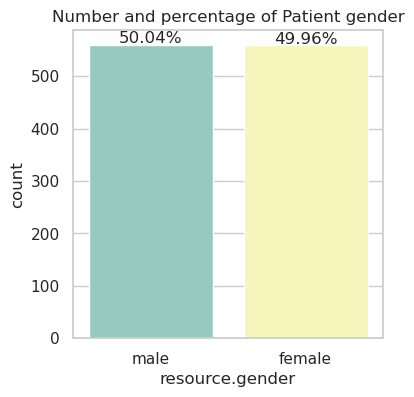

In [41]:
plot_count("resource.gender", "Patient gender", df=patient_df, size=1)

In [42]:
from datetime import datetime as dt
patient_df["birth_date"] = patient_df["resource.birthDate"].apply(lambda x: dt.strptime(x, '%Y-%m-%d'))
patient_df["birth_year"] = patient_df["birth_date"].apply(lambda x: x.year)

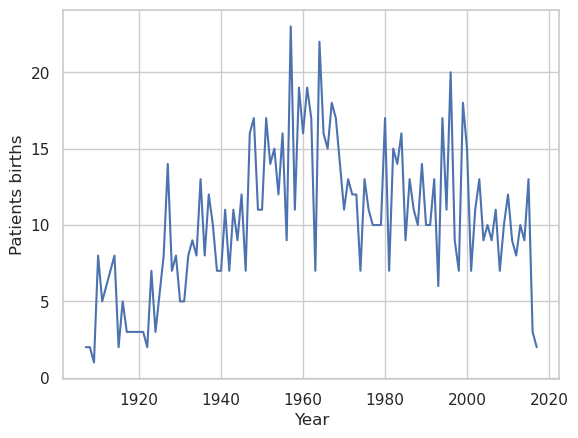

In [43]:
agg_year = patient_df.groupby(["birth_year"])["resource.gender"].count().reset_index()
agg_year.columns = ["birth_year", "count"]
plt.plot(agg_year["birth_year"], agg_year["count"])
plt.title = "Patients births / year"
plt.xlabel("Year")
plt.ylabel("Patients births")
plt.show()

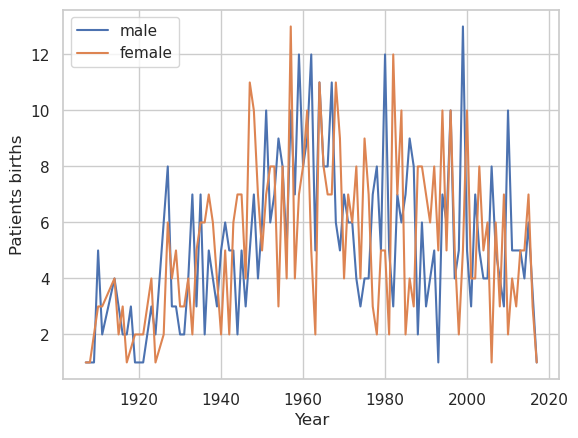

In [44]:
agg_year = patient_df.groupby(["birth_year", "resource.gender"])["resource.telecom"].count().reset_index()
agg_year.columns = ["birth_year", "gender", "count"]
plt.plot(agg_year.loc[agg_year.gender=="male", "birth_year"], agg_year.loc[agg_year.gender=="male", "count"], label="male")
plt.plot(agg_year.loc[agg_year.gender=="female", "birth_year"], agg_year.loc[agg_year.gender=="female", "count"], label="female")
plt.title = "Patients births / year"
plt.xlabel("Year")
plt.ylabel("Patients births")
plt.legend()
plt.show()

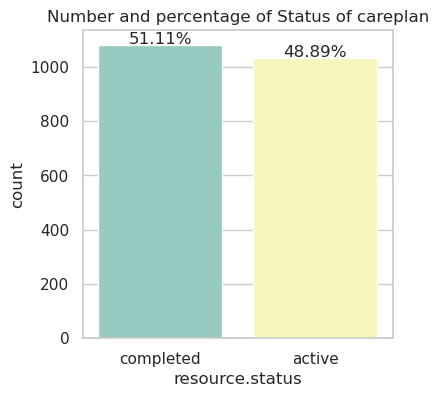

In [45]:
plot_count("resource.status", "Status of careplan", df=careplan_df, size=1)

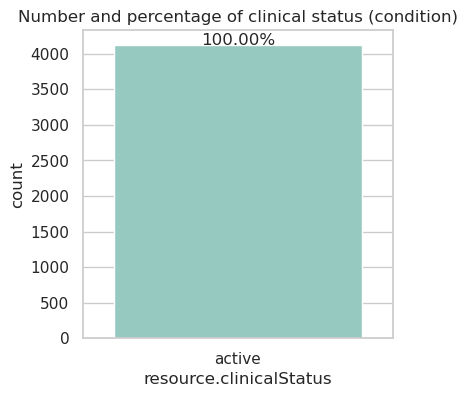

In [46]:
plot_count("resource.clinicalStatus", "clinical status (condition)", df=condition_df, size=1)

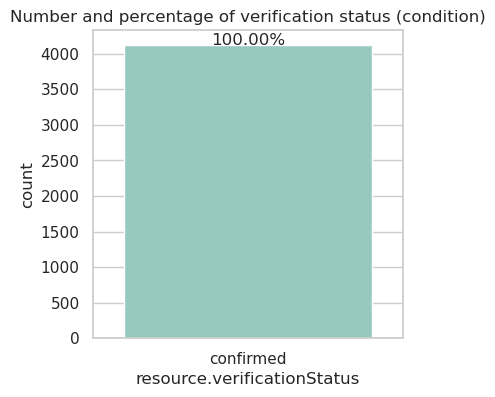

In [47]:
plot_count("resource.verificationStatus", "verification status (condition)", df=condition_df, size=1)

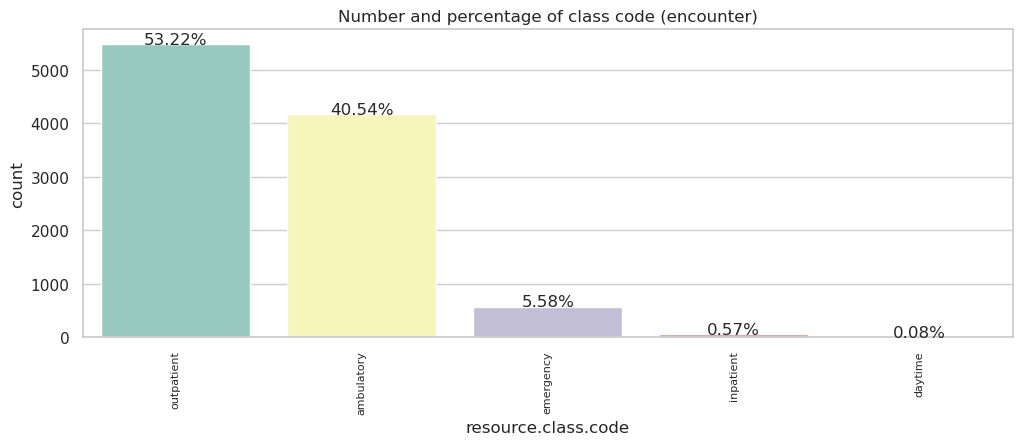

In [48]:
plot_count("resource.class.code", "class code (encounter)", df=encounter_df, size=3)

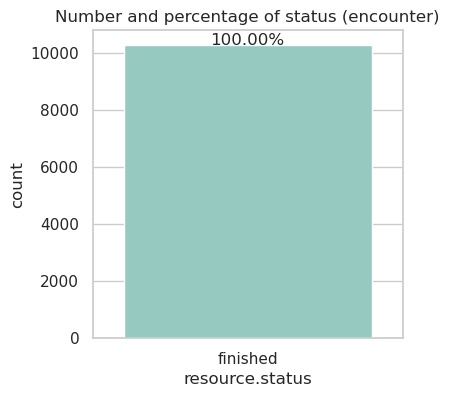

In [49]:
plot_count("resource.status", "status (encounter)", df=encounter_df, size=1)

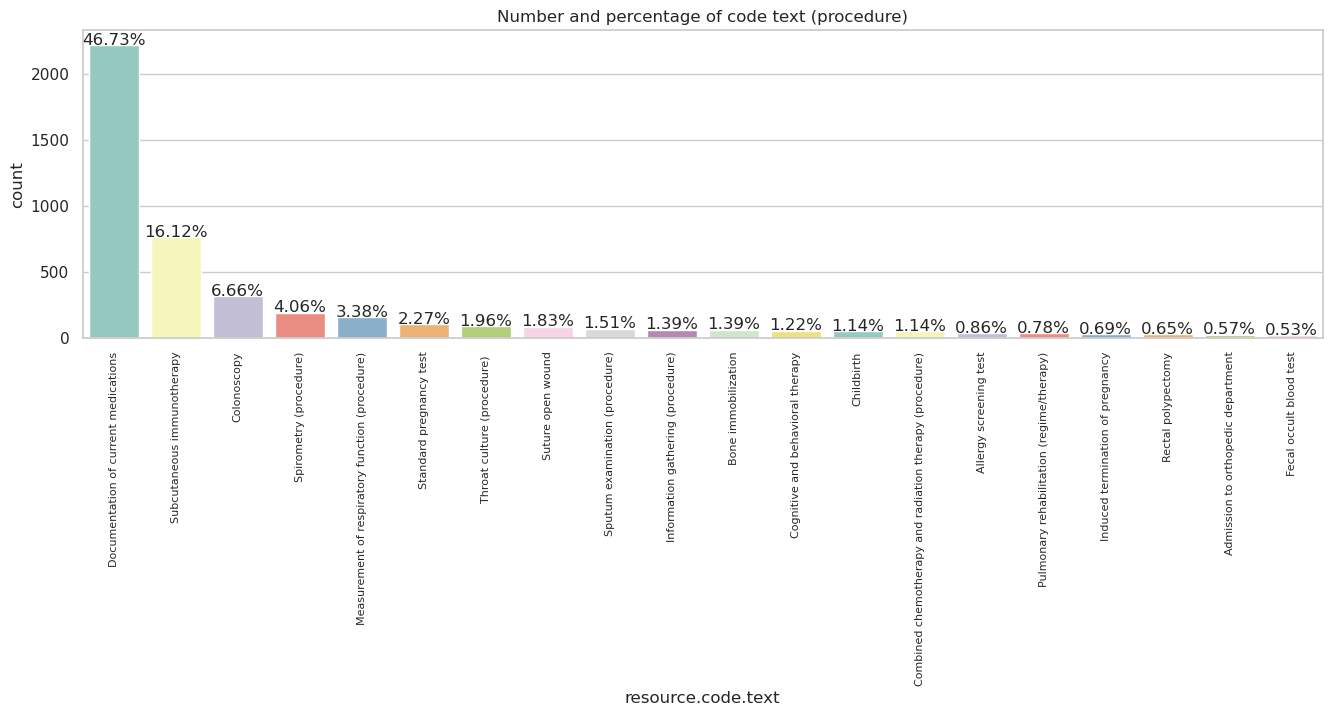

In [50]:
plot_count("resource.code.text", "code text (procedure)", df=procedure_df, size=4)

## Further process data points

Let's further process some of the data points to extract more details about the observations.

In [51]:
observation_df.head()

,fullUrl,resource.id,resource.status,resource.code.coding,resource.subject.reference,resource.encounter.reference,resource.effectiveDateTime,resource.valueQuantity.value,resource.valueQuantity.unit,resource.valueQuantity.system,resource.valueQuantity.code,resource.resourceType,resource.component,resource.valueCodeableConcept.coding
0,urn:uuid:754ebeba-1981-4bac-a44d-6d3938fa1d9f,754ebeba-1981-4bac-a44d-6d3938fa1d9f,final,"[{'system': 'http://loinc.org', 'code': '8302-...",urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,urn:uuid:3236bb53-15ed-4de4-93e7-86b5e46d6dd8,2010-03-29T05:12:01-04:00,173.513618,cm,http://unitsofmeasure.org/,cm,Observation,NaN,NaN
0,urn:uuid:a88f44b8-1688-4926-bf80-2fb65ea0efd5,a88f44b8-1688-4926-bf80-2fb65ea0efd5,final,"[{'system': 'http://loinc.org', 'code': '29463...",urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,urn:uuid:3236bb53-15ed-4de4-93e7-86b5e46d6dd8,2010-03-29T05:12:01-04:00,67.148316,kg,http://unitsofmeasure.org/,kg,Observation,NaN,NaN
0,urn:uuid:e7c6547d-7bdc-49bf-b914-dcf5a93b9761,e7c6547d-7bdc-49bf-b914-dcf5a93b9761,final,"[{'system': 'http://loinc.org', 'code': '39156...",urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,urn:uuid:3236bb53-15ed-4de4-93e7-86b5e46d6dd8,2010-03-29T05:12:01-04:00,22.303242,kg/m2,http://unitsofmeasure.org/,kg/m2,Observation,NaN,NaN
0,urn:uuid:699c6c47-5a09-4a2f-a2ef-ee2bfe53f1c9,699c6c47-5a09-4a2f-a2ef-ee2bfe53f1c9,final,"[{'system': 'http://loinc.org', 'code': '55284...",urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,urn:uuid:3236bb53-15ed-4de4-93e7-86b5e46d6dd8,2010-03-29T05:12:01-04:00,NaN,NaN,NaN,NaN,Observation,[{'code': {'coding': [{'system': 'http://loinc...,NaN
0,urn:uuid:395afc41-8941-42fe-abf5-833304c0e368,395afc41-8941-42fe-abf5-833304c0e368,final,"[{'system': 'http://loinc.org', 'code': '8302-...",urn:uuid:c0be7c6f-142e-4598-b7a4-aa6a4a75588a,urn:uuid:0b9d0d55-5046-475d-b5c9-3e0533524794,2013-09-09T15:50:47-04:00,173.513618,cm,http://unitsofmeasure.org/,cm,Observation,NaN,NaN


In [52]:
observation_df.iloc[0]["resource.code.coding"]

[{'system': 'http://loinc.org', 'code': '8302-2', 'display': 'Body Height'}]

In [53]:
def extract_subitems_by_name(item_list, name):
    for item in item_list:
        if item[name]:
            return item[name]
            
def extract_one_subitem_by_name(item_list, name):
    return item_list[0][name]



In [54]:
observation_df["date"] = observation_df["resource.effectiveDateTime"].apply(lambda x: dt.strptime(x[0:10], '%Y-%m-%d'))

In [55]:
observation_df["resource.code.code"] = observation_df["resource.code.coding"].apply(lambda x: extract_one_subitem_by_name(x, 'code'))
observation_df["resource.code.display"] = observation_df["resource.code.coding"].apply(lambda x: extract_one_subitem_by_name(x, 'display'))

We would like to extract all data from 

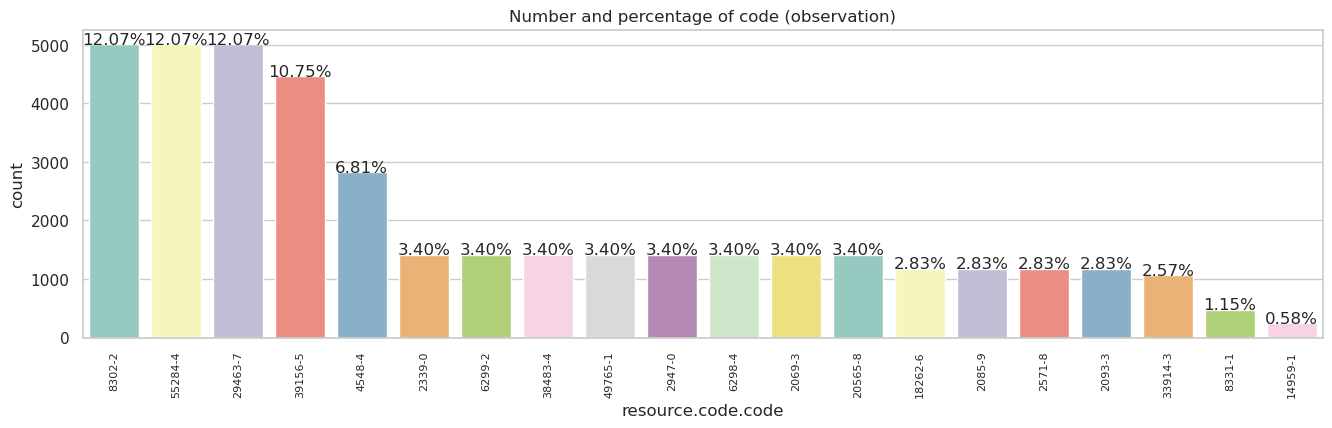

In [56]:
plot_count("resource.code.code", "code (observation)", df=observation_df, size=4)

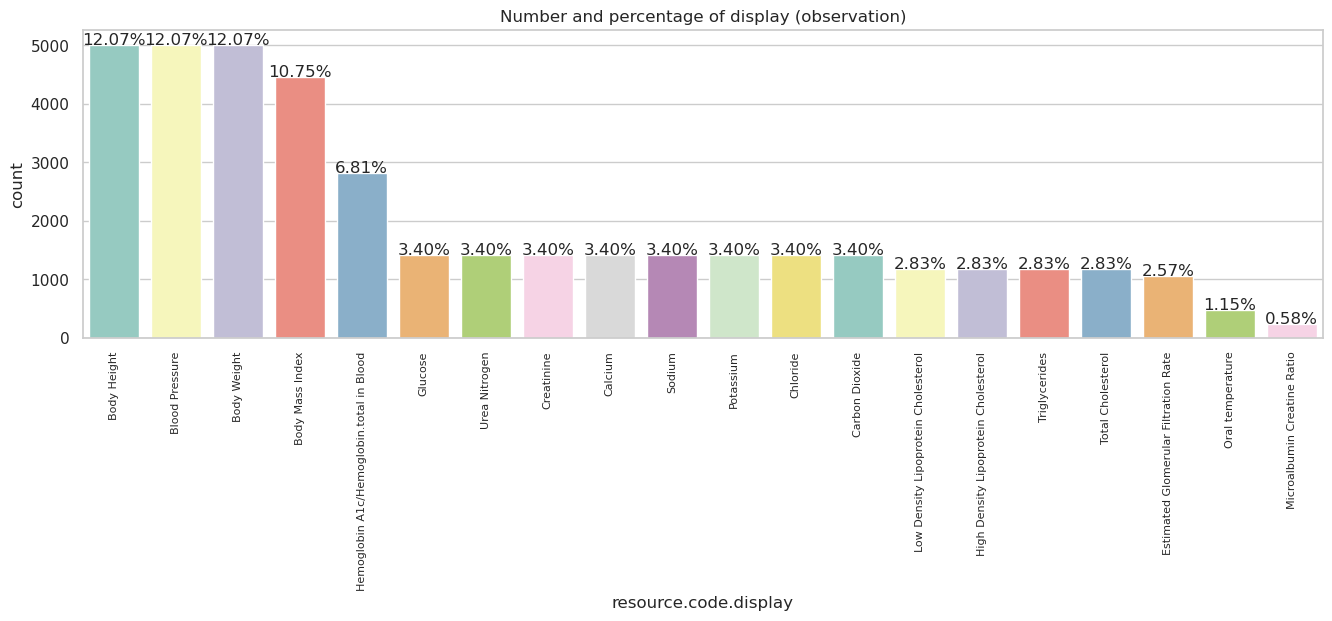

In [57]:
plot_count("resource.code.display", "display (observation)", df=observation_df, size=4)

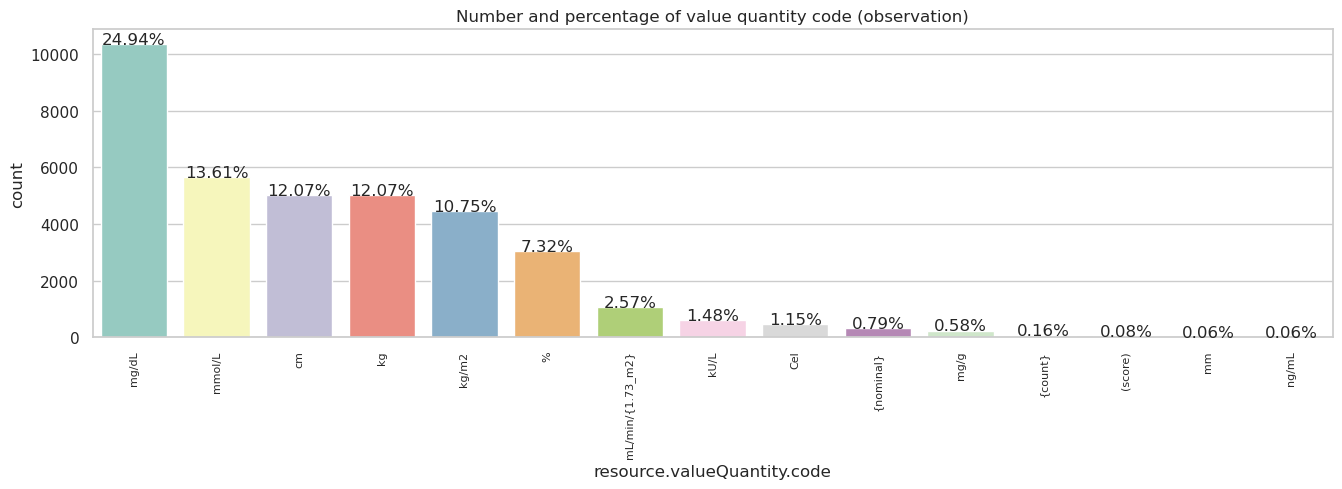

In [58]:
plot_count("resource.valueQuantity.code", "value quantity code (observation)", df=observation_df, size=4)

## Few observation data distributions

We show now the data distribution for the observations, grouped by code.display.

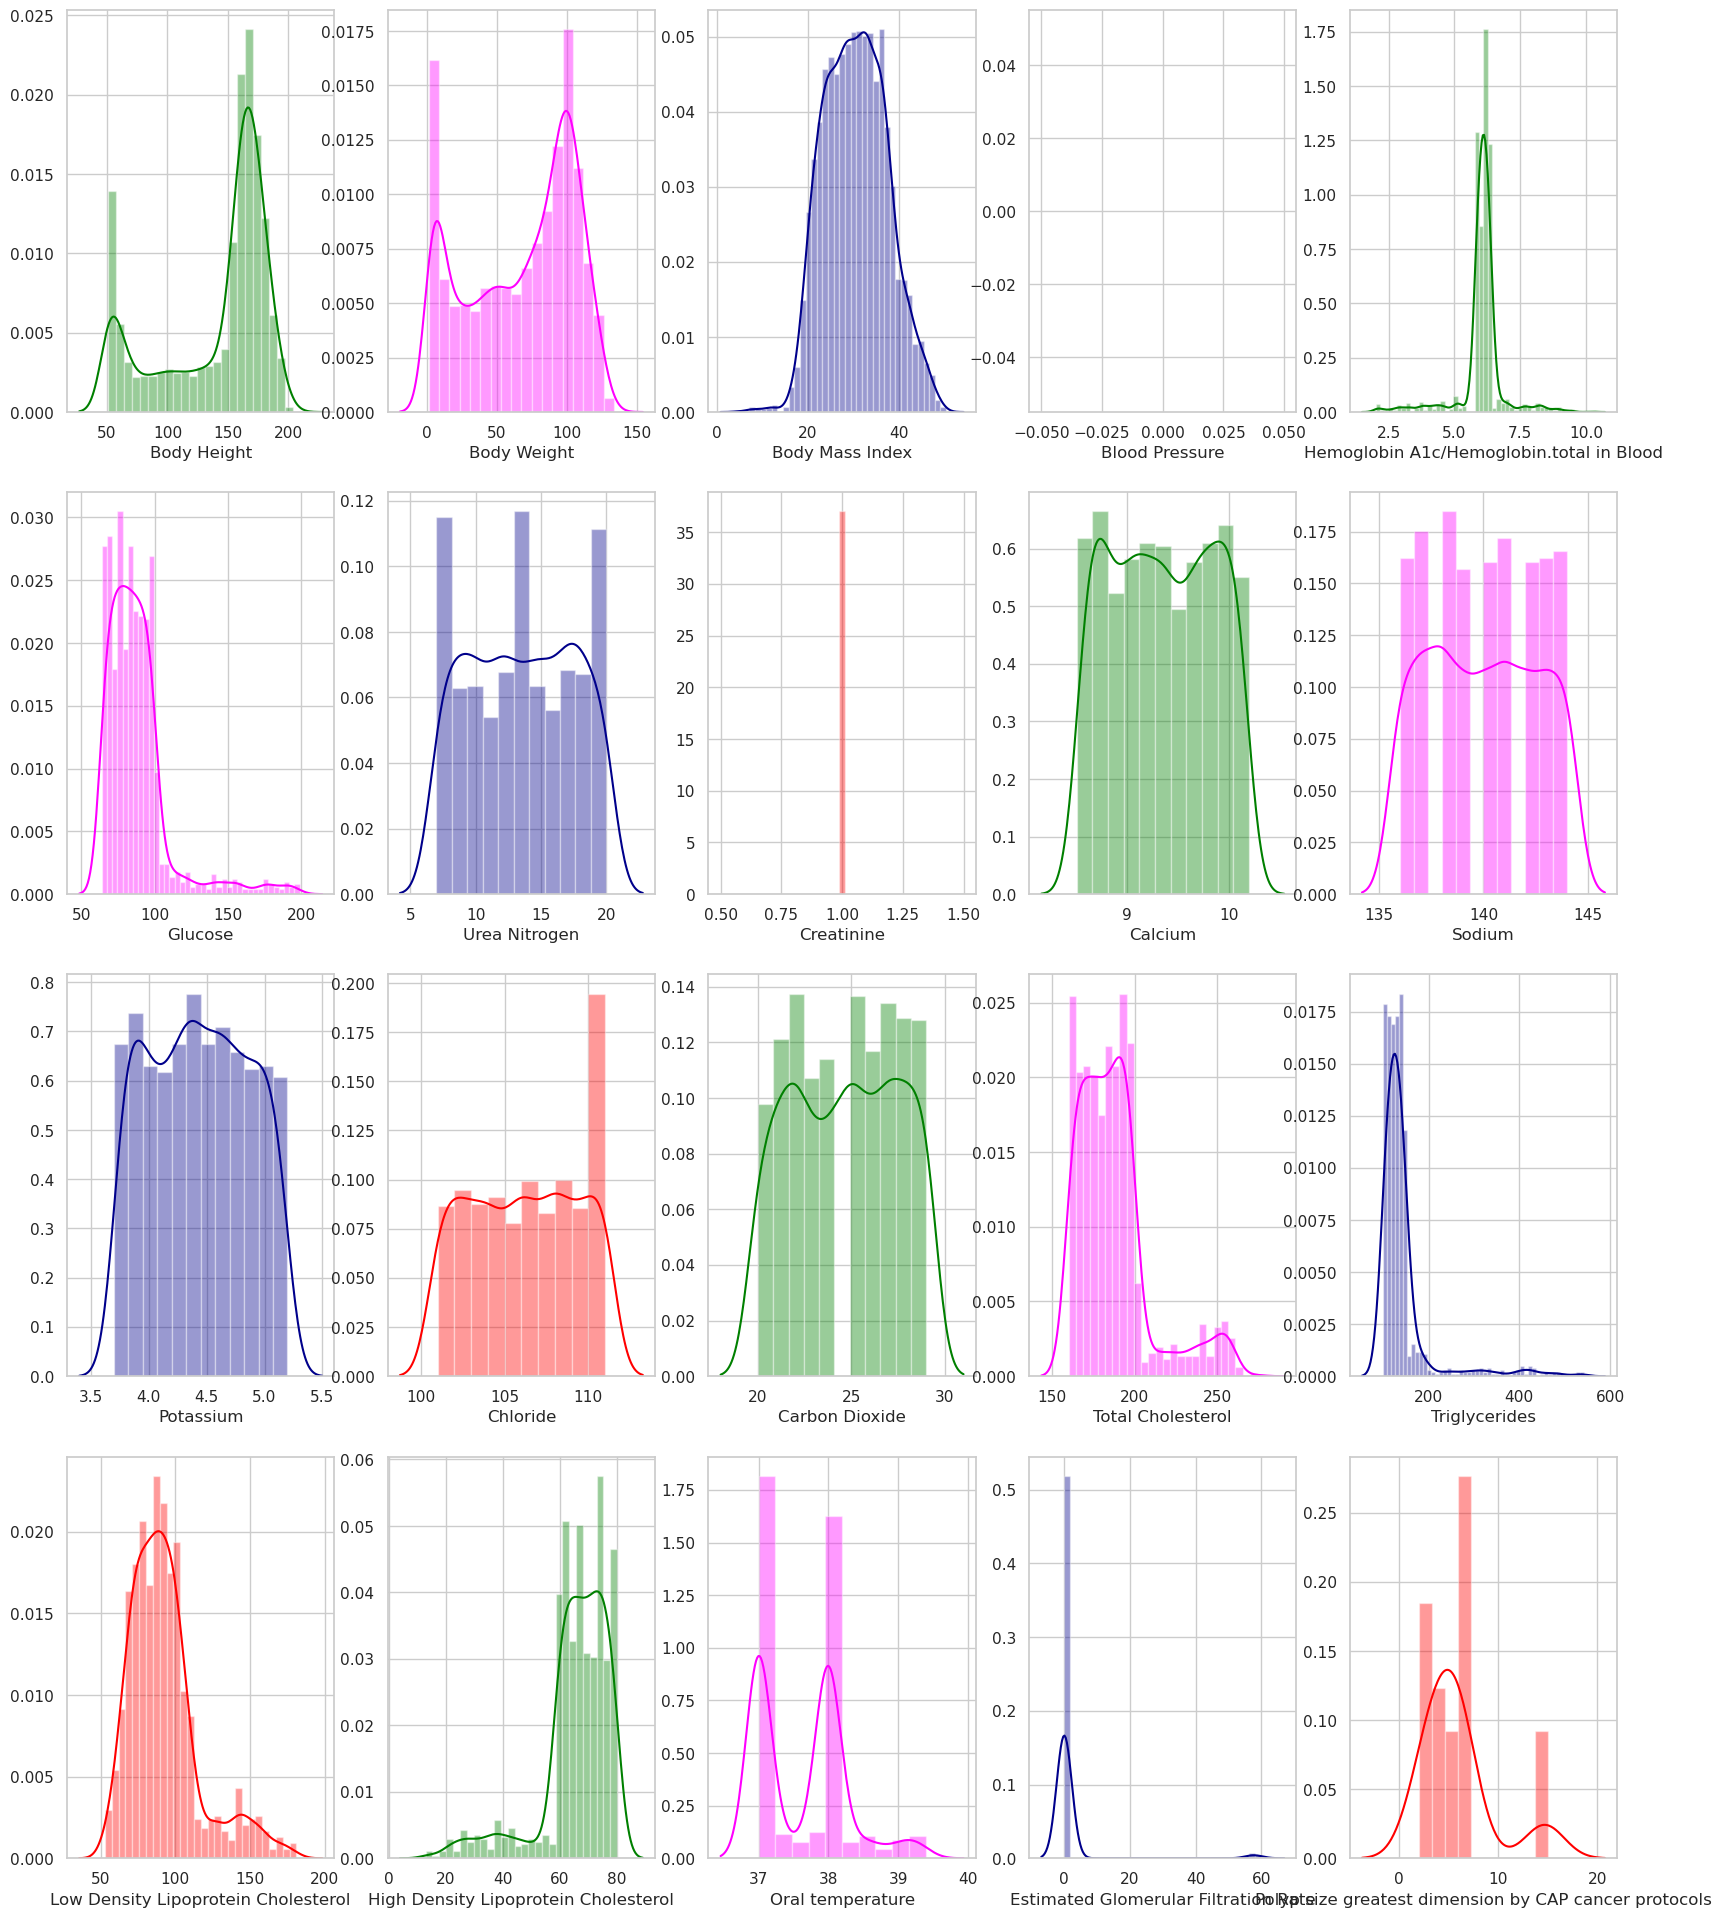

In [59]:
resource_code_display = observation_df["resource.code.display"].unique()
f, ax = plt.subplots(4, 5, figsize=(20, 24))
i = 0
colors = ["red", "green", "magenta", "darkblue"]
for display in resource_code_display[0:20]:
    i += 1
    plt.subplot(4, 5,i)
    sel_df = observation_df.loc[observation_df["resource.code.display"]==display]
    g = sns.distplot(sel_df["resource.valueQuantity.value"], color=colors[i%4])
    g.set(ylabel=None)
    g.set(xlabel=display)
plt.show()

## Selection of observation data for one patient

Let's select one type of observation for one patient.  
We will select the patient with bigest number of observations available.

In [60]:
sel_patient = observation_df["resource.subject.reference"].value_counts().index[0]
print(sel_patient)
obs_subset_df = observation_df.loc[observation_df["resource.subject.reference"]==sel_patient]

urn:uuid:16f586c1-8124-4382-b36a-d99f8f0ee357


In [61]:
obs_subset_df.head()

,fullUrl,resource.id,resource.status,resource.code.coding,resource.subject.reference,resource.encounter.reference,resource.effectiveDateTime,resource.valueQuantity.value,resource.valueQuantity.unit,resource.valueQuantity.system,resource.valueQuantity.code,resource.resourceType,resource.component,resource.valueCodeableConcept.coding,date,resource.code.code,resource.code.display
0,urn:uuid:59907111-4d6a-40e1-a38c-1900ef4e377d,59907111-4d6a-40e1-a38c-1900ef4e377d,final,"[{'system': 'http://loinc.org', 'code': '4548-...",urn:uuid:16f586c1-8124-4382-b36a-d99f8f0ee357,urn:uuid:286ae6b7-75e3-4dde-9632-82230ea402eb,2010-07-16T00:17:43-04:00,6.300000,%,http://unitsofmeasure.org/,%,Observation,NaN,NaN,2010-07-16,4548-4,Hemoglobin A1c/Hemoglobin.total in Blood
0,urn:uuid:aa043e5b-ba00-489e-b6a6-e56ad88255b3,aa043e5b-ba00-489e-b6a6-e56ad88255b3,final,"[{'system': 'http://loinc.org', 'code': '8302-...",urn:uuid:16f586c1-8124-4382-b36a-d99f8f0ee357,urn:uuid:286ae6b7-75e3-4dde-9632-82230ea402eb,2010-07-16T00:17:43-04:00,178.097427,cm,http://unitsofmeasure.org/,cm,Observation,NaN,NaN,2010-07-16,8302-2,Body Height
0,urn:uuid:7d63ec02-e455-4c1b-bd4a-cde1a42cbb13,7d63ec02-e455-4c1b-bd4a-cde1a42cbb13,final,"[{'system': 'http://loinc.org', 'code': '29463...",urn:uuid:16f586c1-8124-4382-b36a-d99f8f0ee357,urn:uuid:286ae6b7-75e3-4dde-9632-82230ea402eb,2010-07-16T00:17:43-04:00,99.508004,kg,http://unitsofmeasure.org/,kg,Observation,NaN,NaN,2010-07-16,29463-7,Body Weight
0,urn:uuid:199fb7b6-ed17-45a2-bb76-cc9b59ab615e,199fb7b6-ed17-45a2-bb76-cc9b59ab615e,final,"[{'system': 'http://loinc.org', 'code': '39156...",urn:uuid:16f586c1-8124-4382-b36a-d99f8f0ee357,urn:uuid:286ae6b7-75e3-4dde-9632-82230ea402eb,2010-07-16T00:17:43-04:00,31.372037,kg/m2,http://unitsofmeasure.org/,kg/m2,Observation,NaN,NaN,2010-07-16,39156-5,Body Mass Index
0,urn:uuid:fd61fac1-f19a-4a0b-a775-ae2c271f6af9,fd61fac1-f19a-4a0b-a775-ae2c271f6af9,final,"[{'system': 'http://loinc.org', 'code': '55284...",urn:uuid:16f586c1-8124-4382-b36a-d99f8f0ee357,urn:uuid:286ae6b7-75e3-4dde-9632-82230ea402eb,2010-07-16T00:17:43-04:00,NaN,NaN,NaN,NaN,Observation,[{'code': {'coding': [{'system': 'http://loinc...,NaN,2010-07-16,55284-4,Blood Pressure


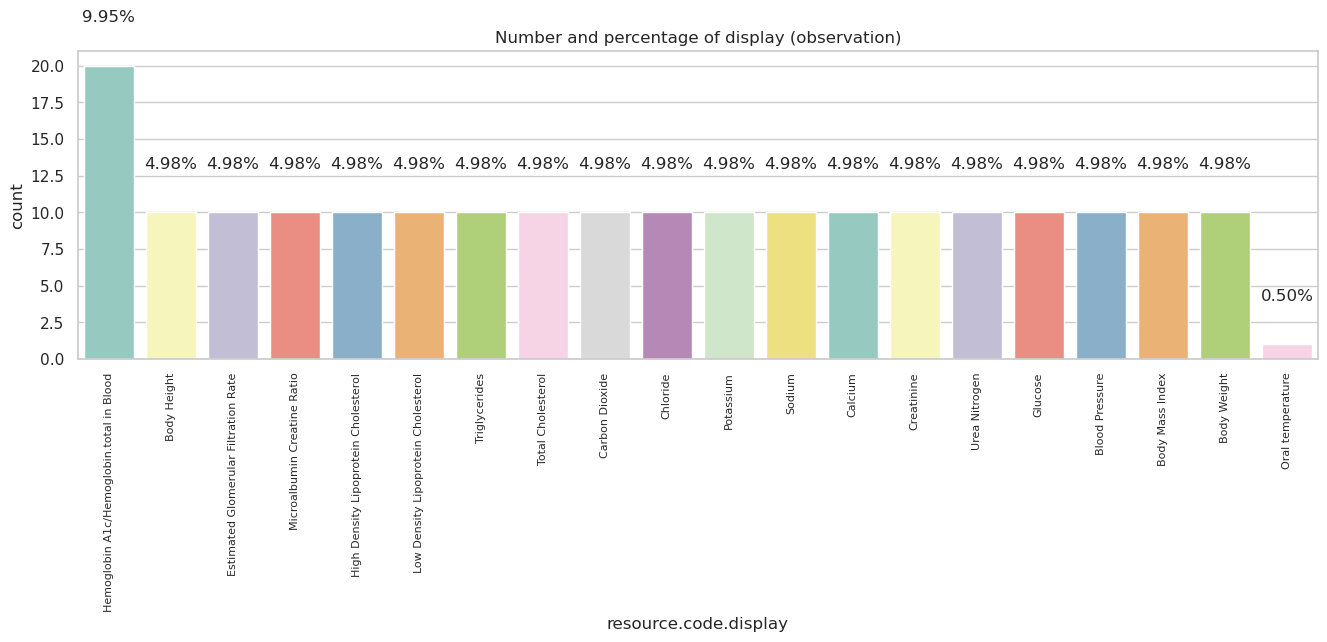

In [62]:
plot_count("resource.code.display", "display (observation)", df=obs_subset_df, size=4)

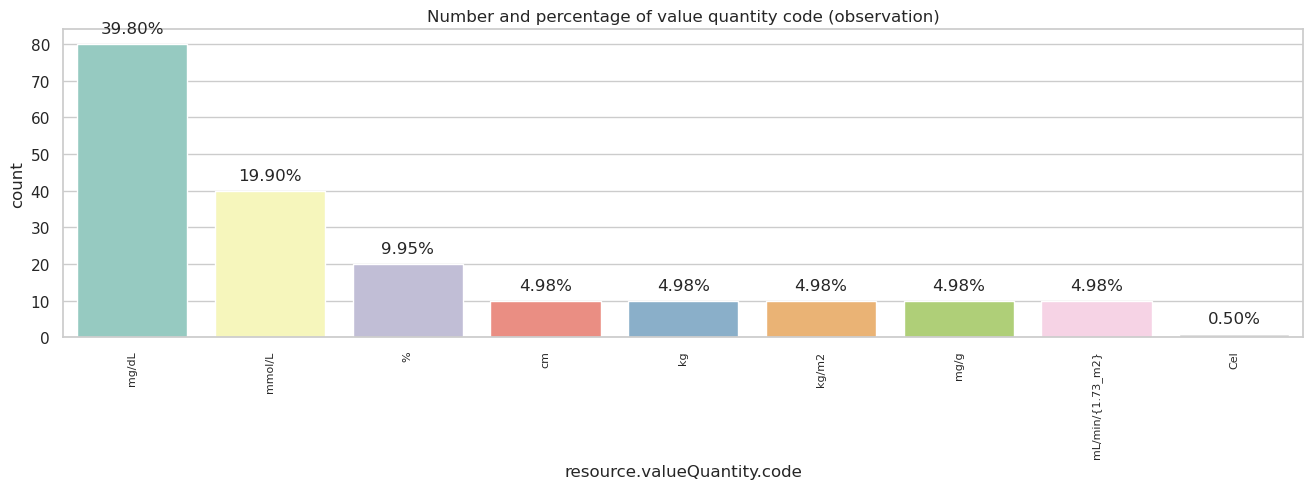

In [63]:
plot_count("resource.valueQuantity.code", "value quantity code (observation)", df=obs_subset_df, size=4)

Let's show now the distribution of few of the data for this patient.

In [64]:
sel_obs_columns = ["resource.code.display", "resource.effectiveDateTime", "resource.valueQuantity.value",
               "resource.valueQuantity.unit","resource.valueQuantity.system","resource.valueQuantity.code", "date"]

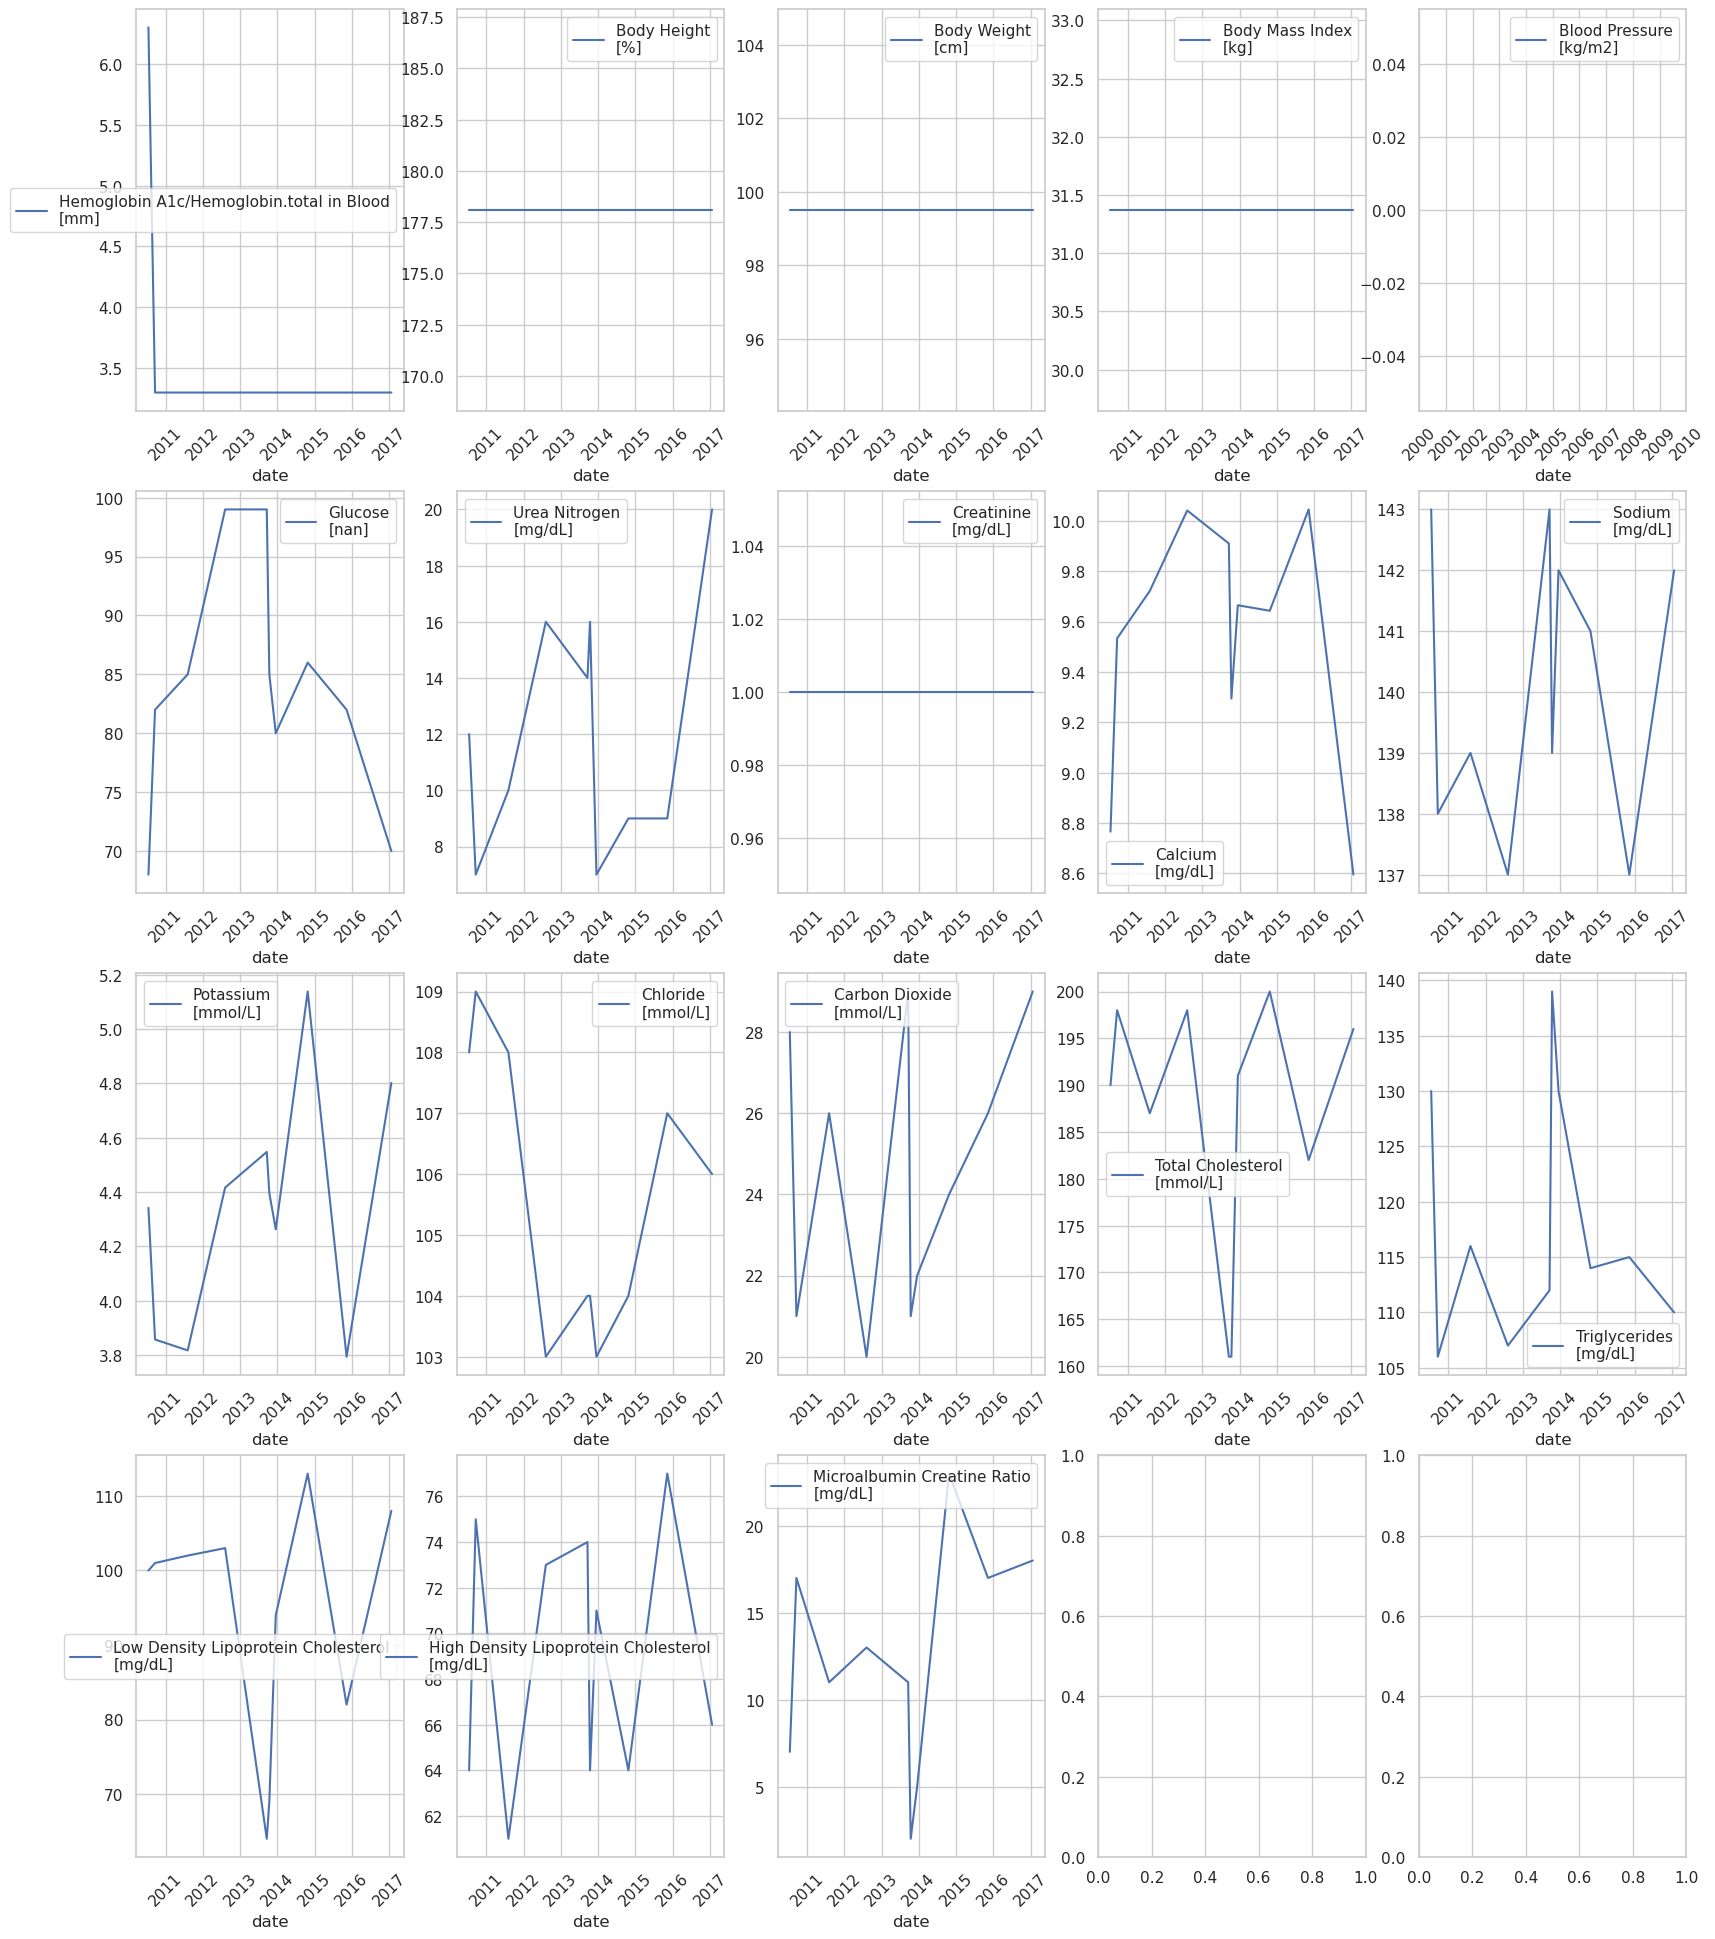

In [65]:
resource_code_display = obs_subset_df["resource.code.display"].unique()



f, ax = plt.subplots(4, 5, figsize=(20, 24))
i = 0
for display in resource_code_display[:-2]:
    i += 1
    plt.subplot(4, 5,i)
    plt.legend(loc=2, prop={'size': 3})
    label_text = f"{display}\n[{sel_df['resource.valueQuantity.code'].values[0]}]"
    sel_df = obs_subset_df.loc[obs_subset_df["resource.code.display"]==display]
    plt.plot(sel_df["date"], sel_df["resource.valueQuantity.value"], label=label_text)
    plt.tick_params(axis='x', rotation=45, size=6)
    plt.xlabel("date")
    plt.legend()
plt.show()
    
    

## More patients

Let's repeat this process for few more patients.

Selected patient: urn:uuid:8a7d1161-f041-4a5a-bb6b-103557f766d0


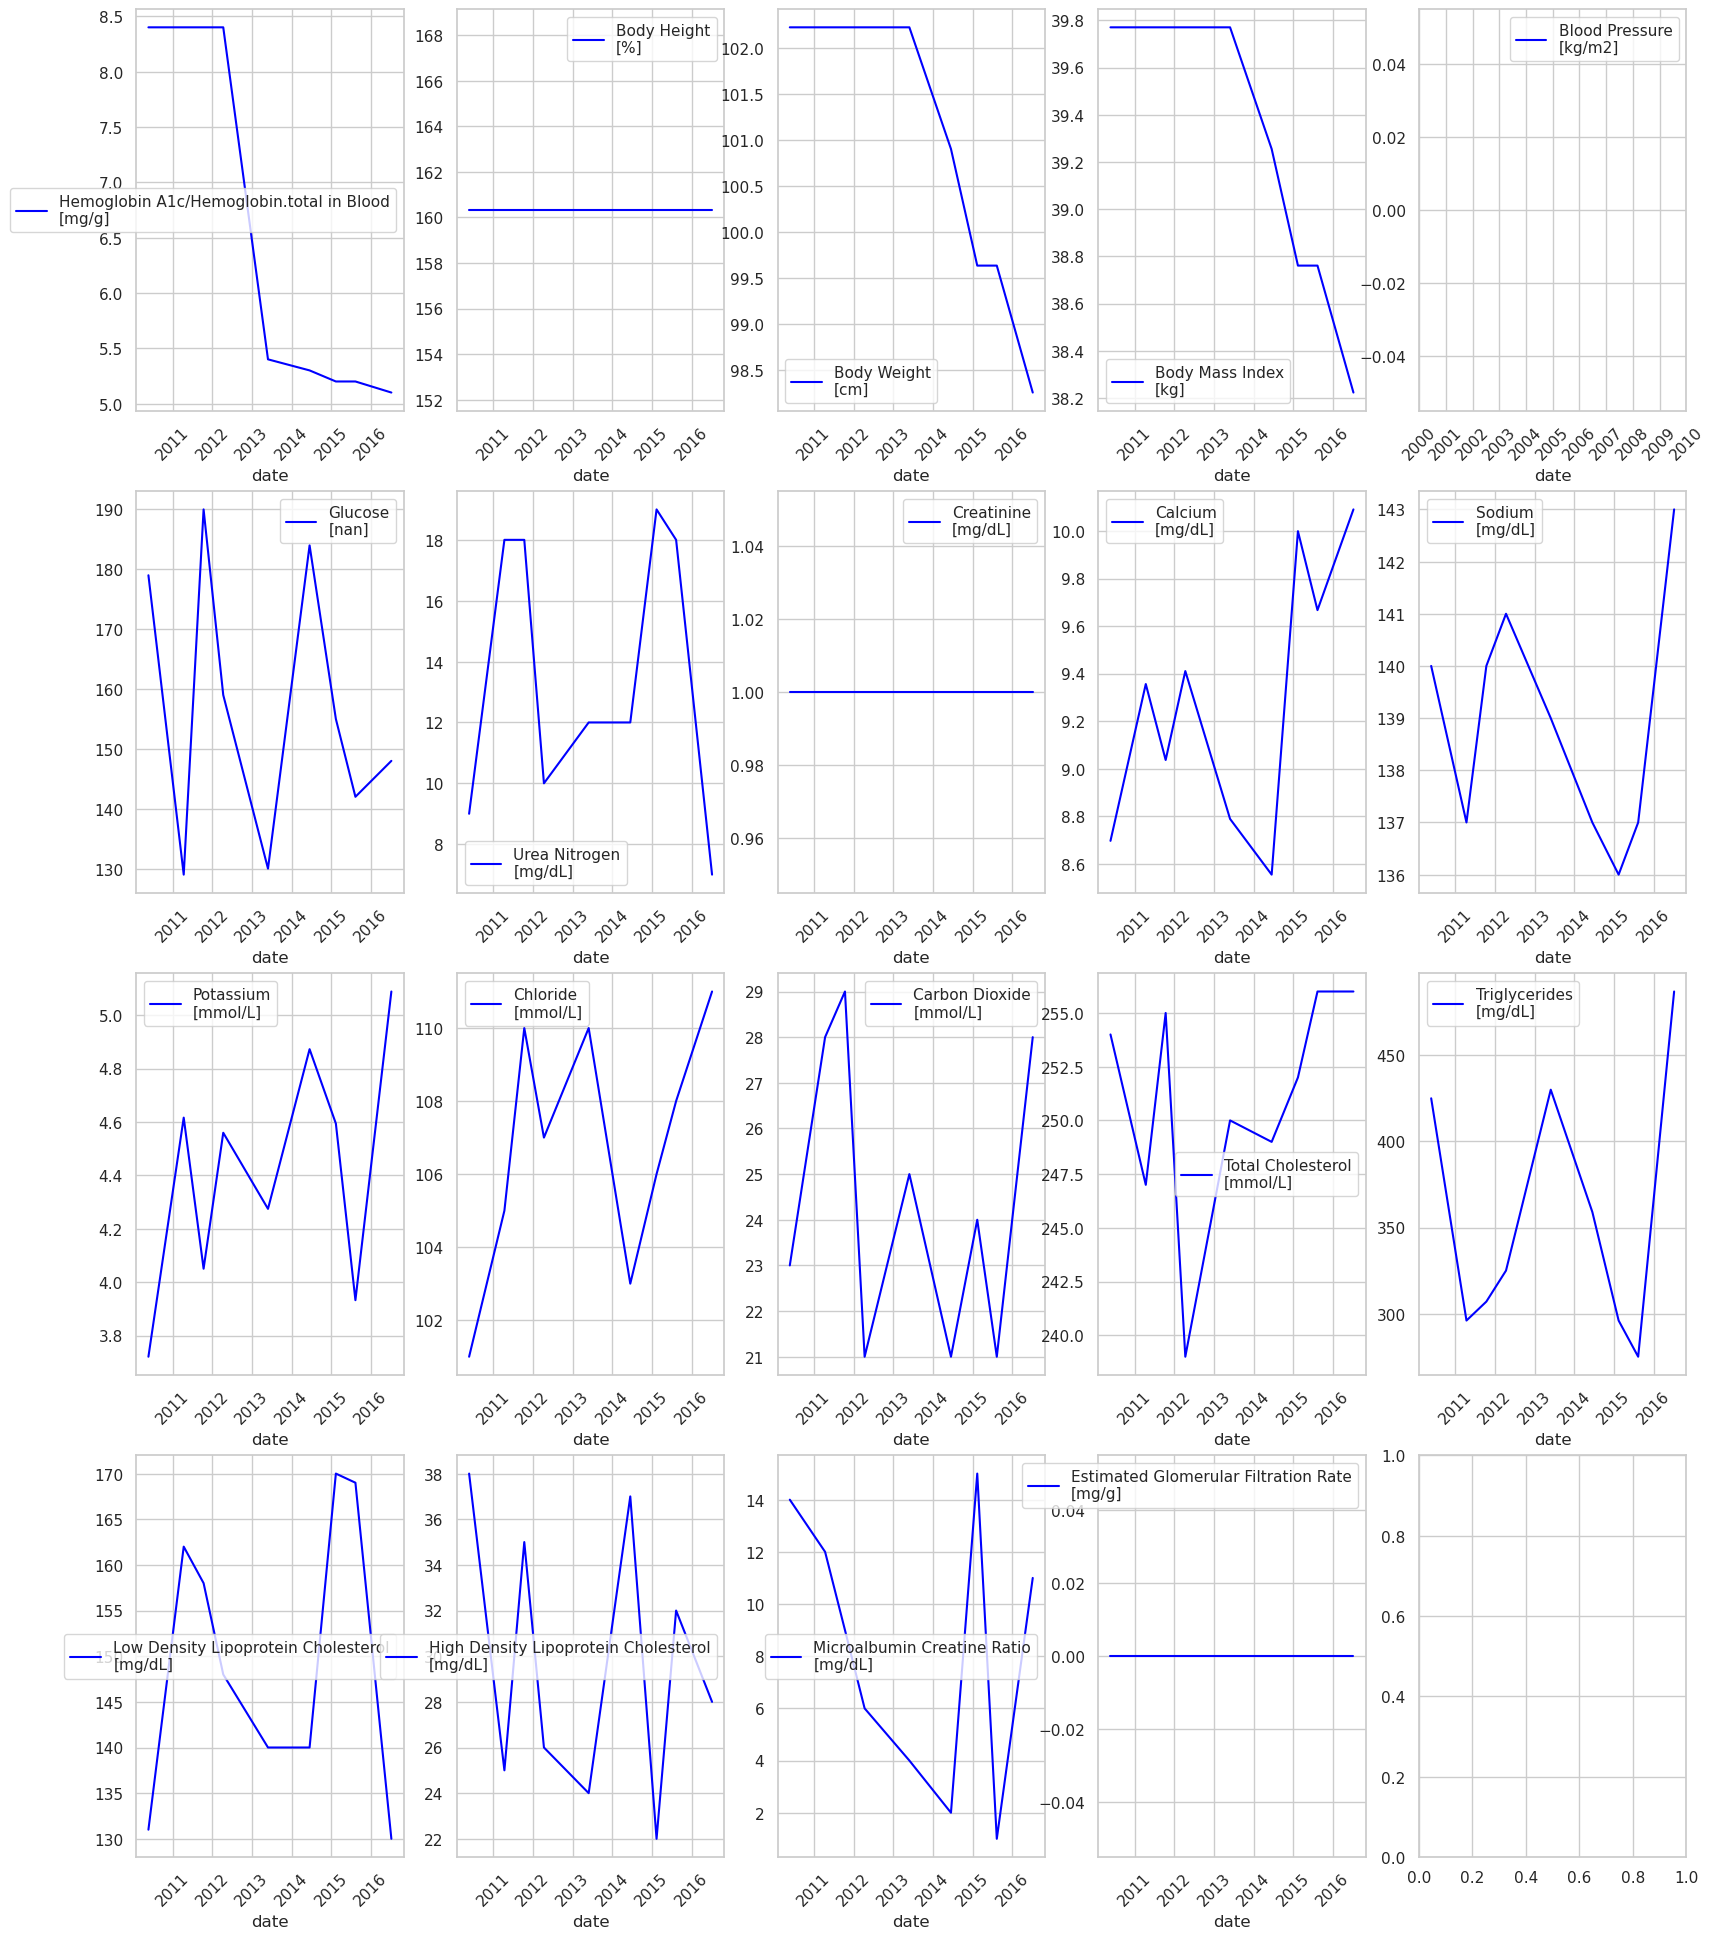

Selected patient: urn:uuid:6bda6597-e27a-4dbc-afa9-2e04cccb8bde


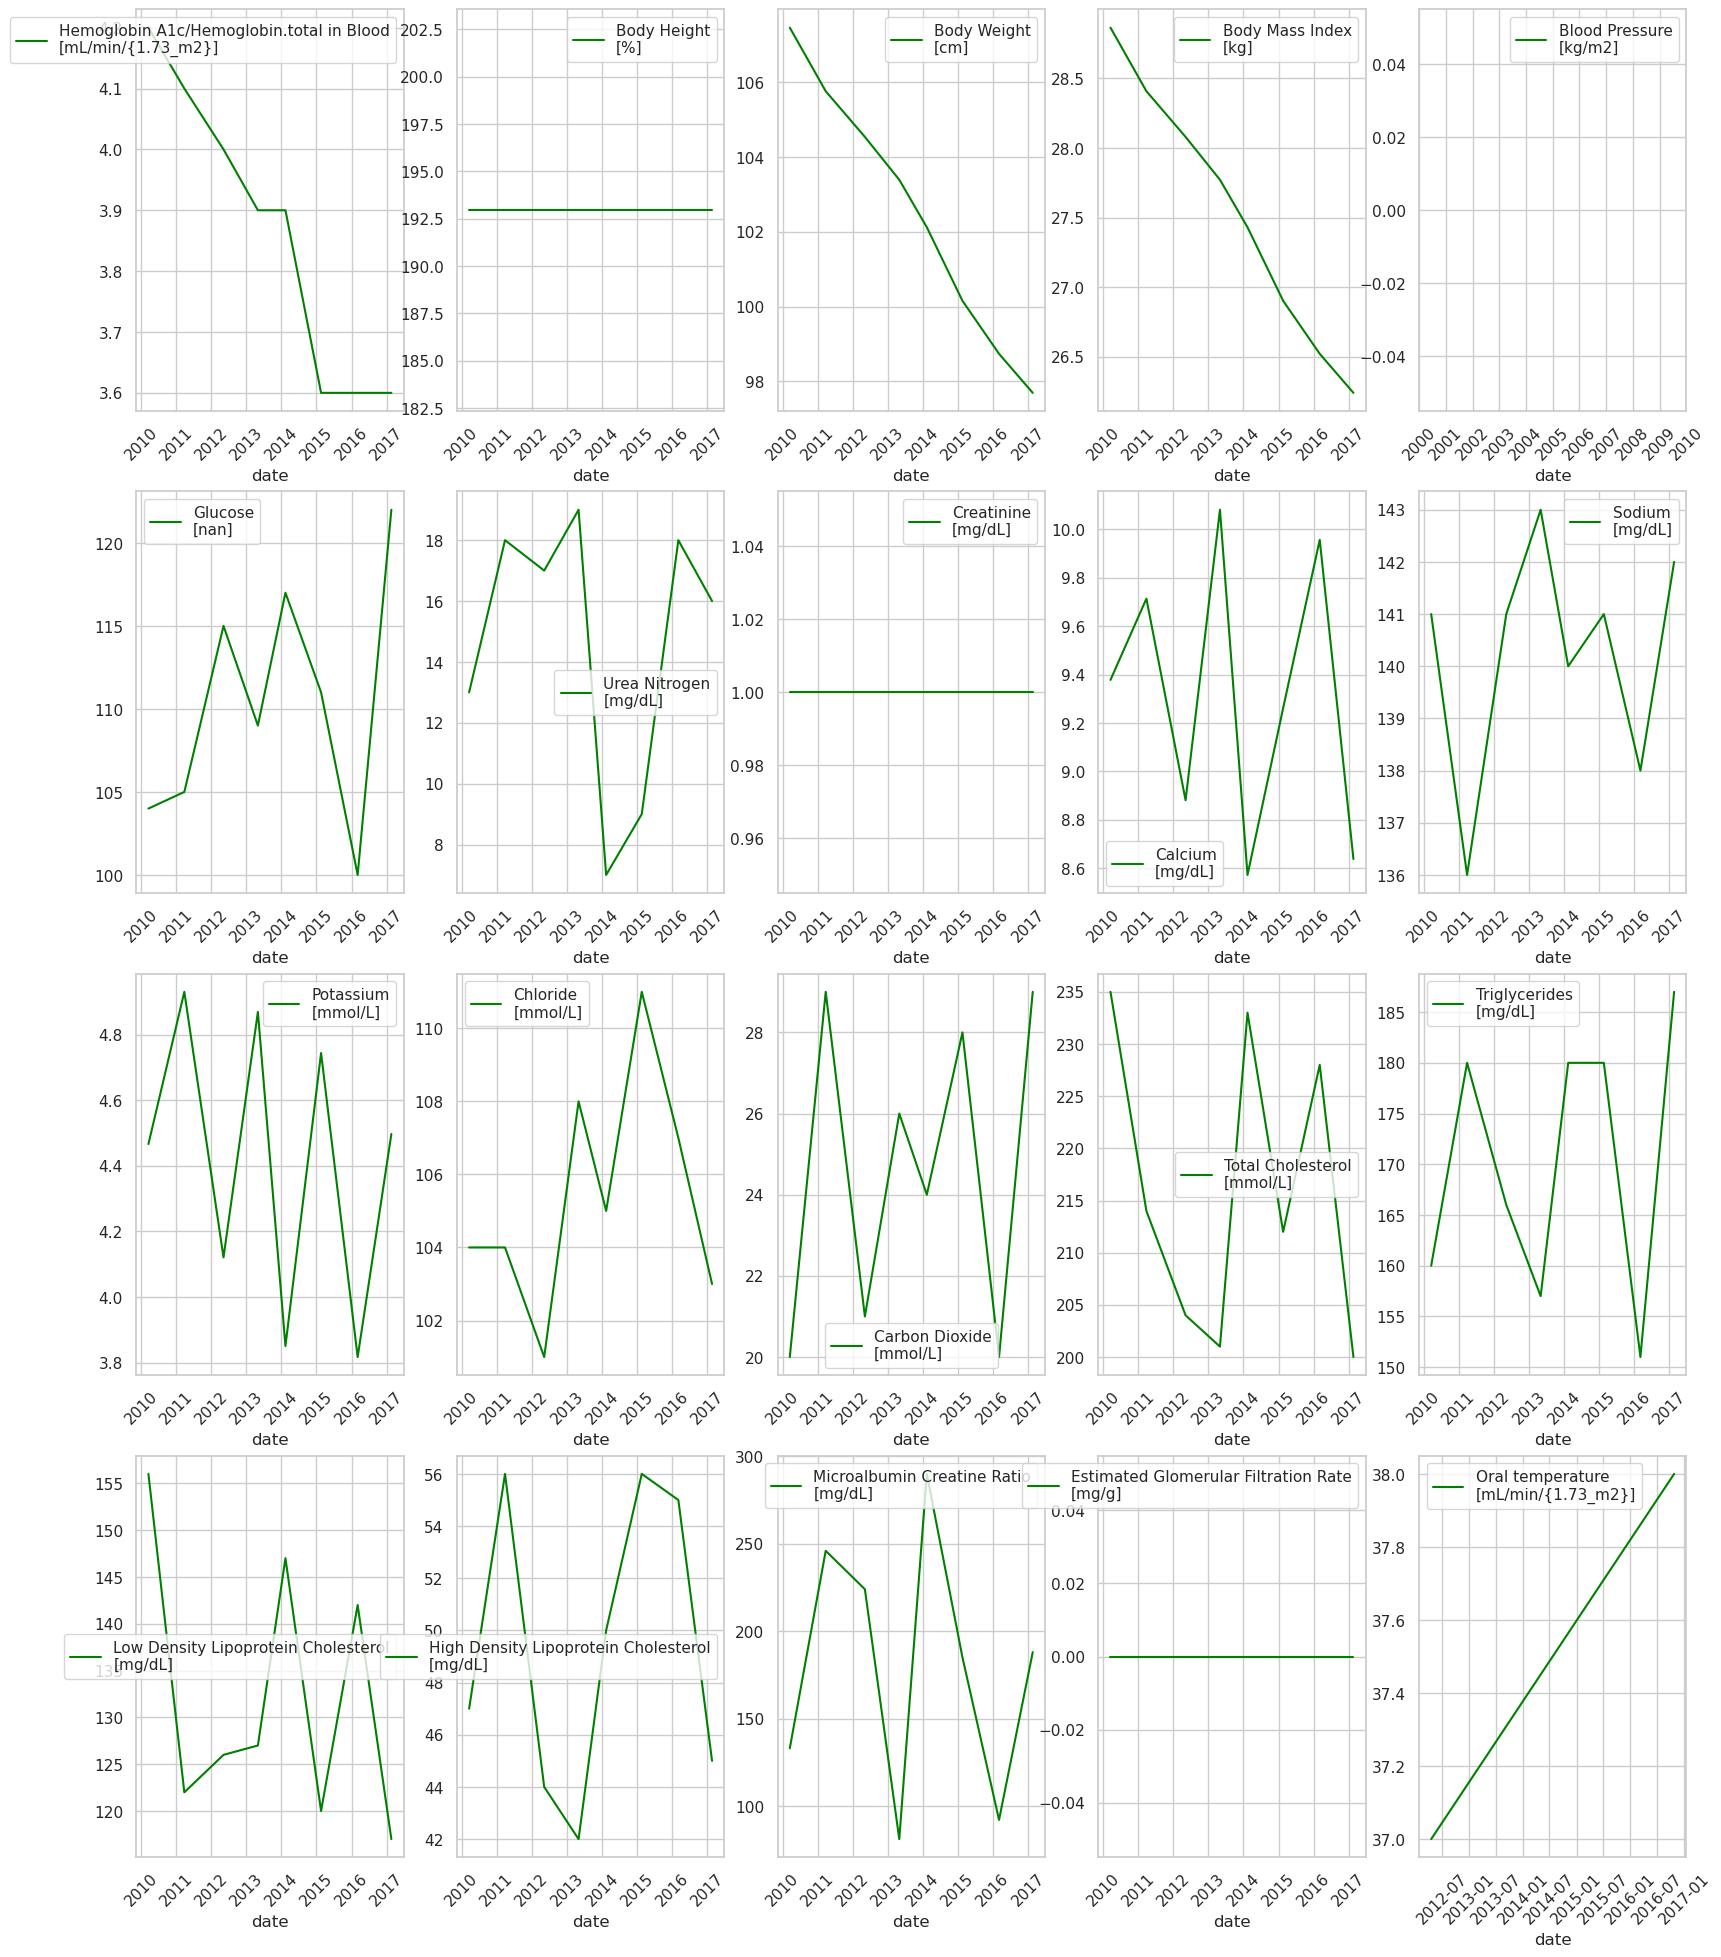

Selected patient: urn:uuid:f18d842b-f133-48b5-89c7-dcfd33333342


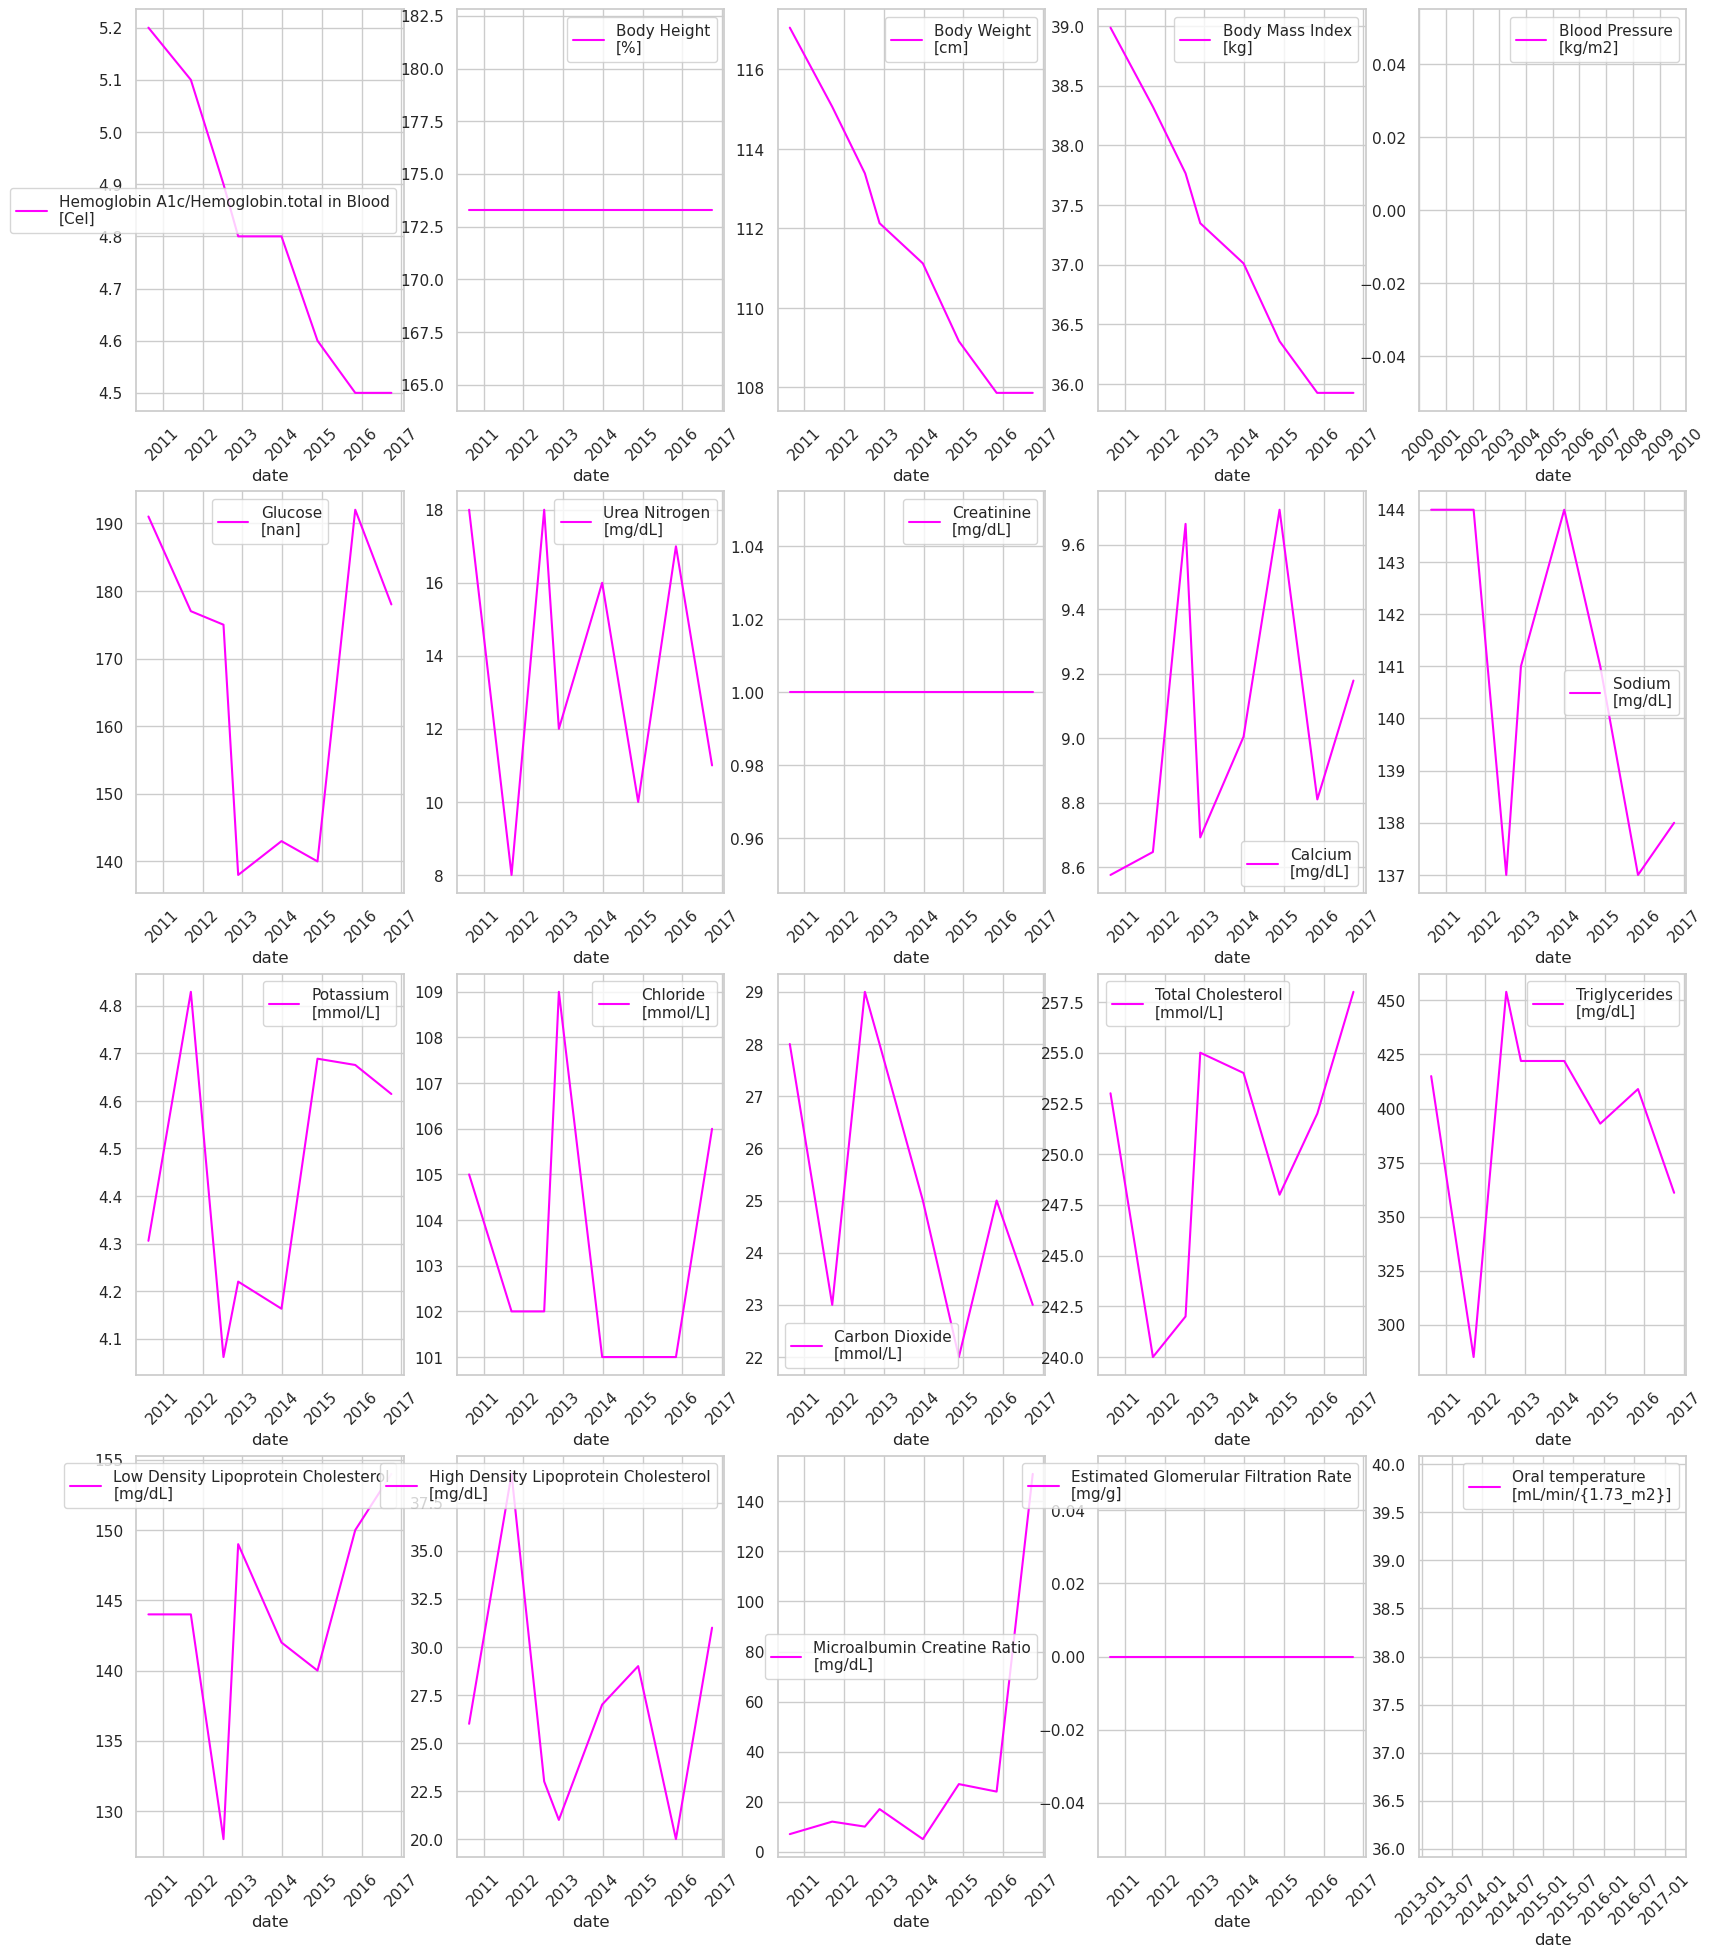

Selected patient: urn:uuid:87c5ab0b-e4a7-424b-8101-80150d30a4fe


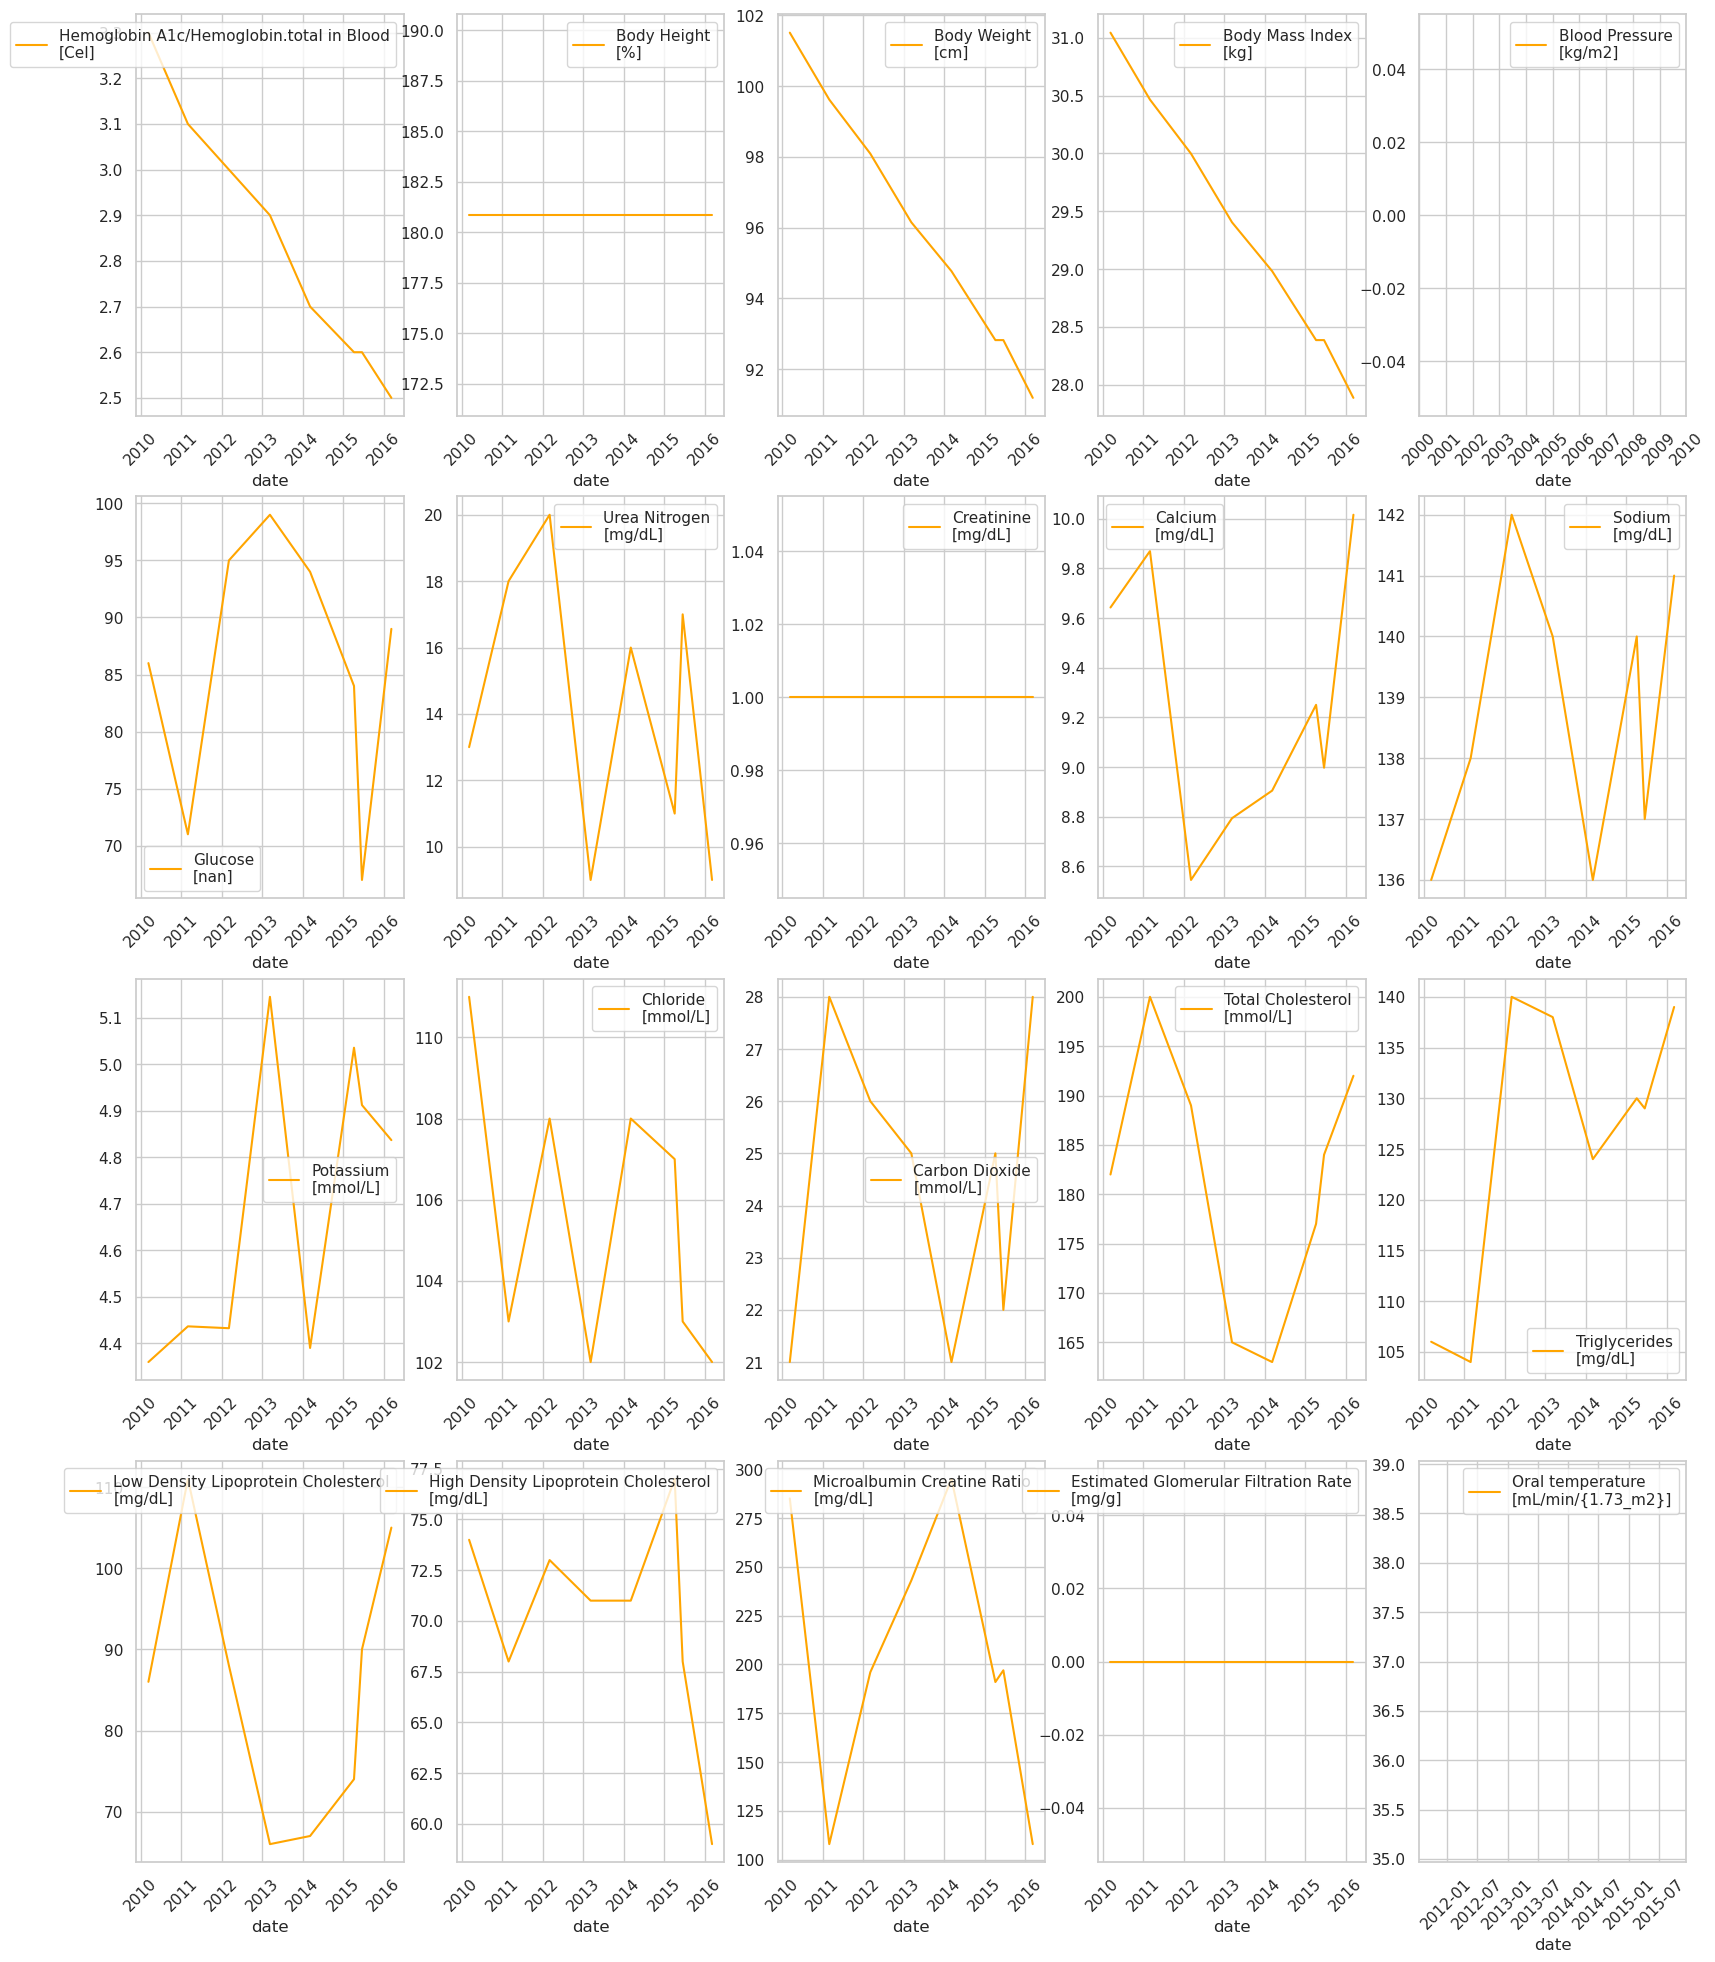

In [66]:
for idx in range(1, 5):
    sel_patient = observation_df["resource.subject.reference"].value_counts().index[idx]
    print(f"Selected patient: {sel_patient}")
    obs_subset_df = observation_df.loc[observation_df["resource.subject.reference"]==sel_patient]
    resource_code_display = obs_subset_df["resource.code.display"].unique()
    colors = ["red", "blue", "green", "magenta", "orange"]
    f, ax = plt.subplots(4, 5, figsize=(20, 24))
    i = 0
    for display in resource_code_display[0:20]:
        i += 1
        plt.subplot(4, 5,i)
        plt.legend(loc=2, prop={'size': 3})
        label_text = f"{display}\n[{sel_df['resource.valueQuantity.code'].values[0]}]"
        sel_df = obs_subset_df.loc[obs_subset_df["resource.code.display"]==display]
        plt.plot(sel_df["date"], sel_df["resource.valueQuantity.value"], label=label_text, color=colors[idx])
        plt.tick_params(axis='x', rotation=45, size=6)
        plt.xlabel("date")
        plt.legend()
    plt.show()

# Summary of findings

The work on data exploration is not completed.   

We extracted patient and observation data in a bit more detail.  

We plotted observation data distribution for the entire patients data selected (see subset selected) as well as per one specific patient.

Further work is needed to extract additional data.  

Suggested future work:

- merge patient data with observation data to get stats on observations grouped by patient age/gender   
- group patient, observation, immunization, procedure, diagnostic data to follow evolution of one patient over time and observe correlations between these data dimmensions 




Work in progress ...